# EDA - Macros

## Setup - Macros

### Import the necessary libraries

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import math

#StatsModels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

#SkLearn
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, r2_score, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Note: Indicates situations that aren’t necessarily exceptions.
import warnings
warnings.filterwarnings('ignore')

### Data Loading and Validation

In [2]:
# Load dataset
df = pd.read_csv('macro_metrics_dataset.csv')

# Convert `date` column to datetime
df['date'] = pd.to_datetime(df['date'])

df.head()

date symbol  RealGDP_pct_YoY  FedDebt_pct_YoY  CPI_pct_YoY  \
0 2001-03-31   AAPL         2.197505         0.006028     2.982456   
1 2001-06-30   AAPL         0.996298         0.718914     3.193961   
2 2001-09-30   AAPL         0.489236         2.348974     2.592166   
3 2001-12-31   AAPL         0.167318         4.966660     1.603666   
4 2002-03-31   AAPL         1.337259         4.023250     1.362862   

   Unemployment_bps_YoY  USTYield_10y_bps_YoY  revenue_qtly_YoY  \
0                   0.3                 -1.10        -26.426735   
1                   0.5                 -0.61        -19.178082   
2                   1.1                 -1.20        -22.459893   
3                   1.8                 -0.05         36.544191   
4                   1.4                  0.49          4.472397   

   operatingCashFlow_qtly_YoY  Return_pct_YoY  eps_qtly_pct_YoY  
0                 -172.131148       -0.674993        -78.217822  
1                 -114.102564       -0.556086        -75.781250  
2                   74.050633       -0.397670        -63.440860  
3                 -423.076923        0.472267       -117.272727  
4                 -104.545455        0.072498         -9.090909

## Correlation Analysis - Macros

### Individual Correlation Heatmaps

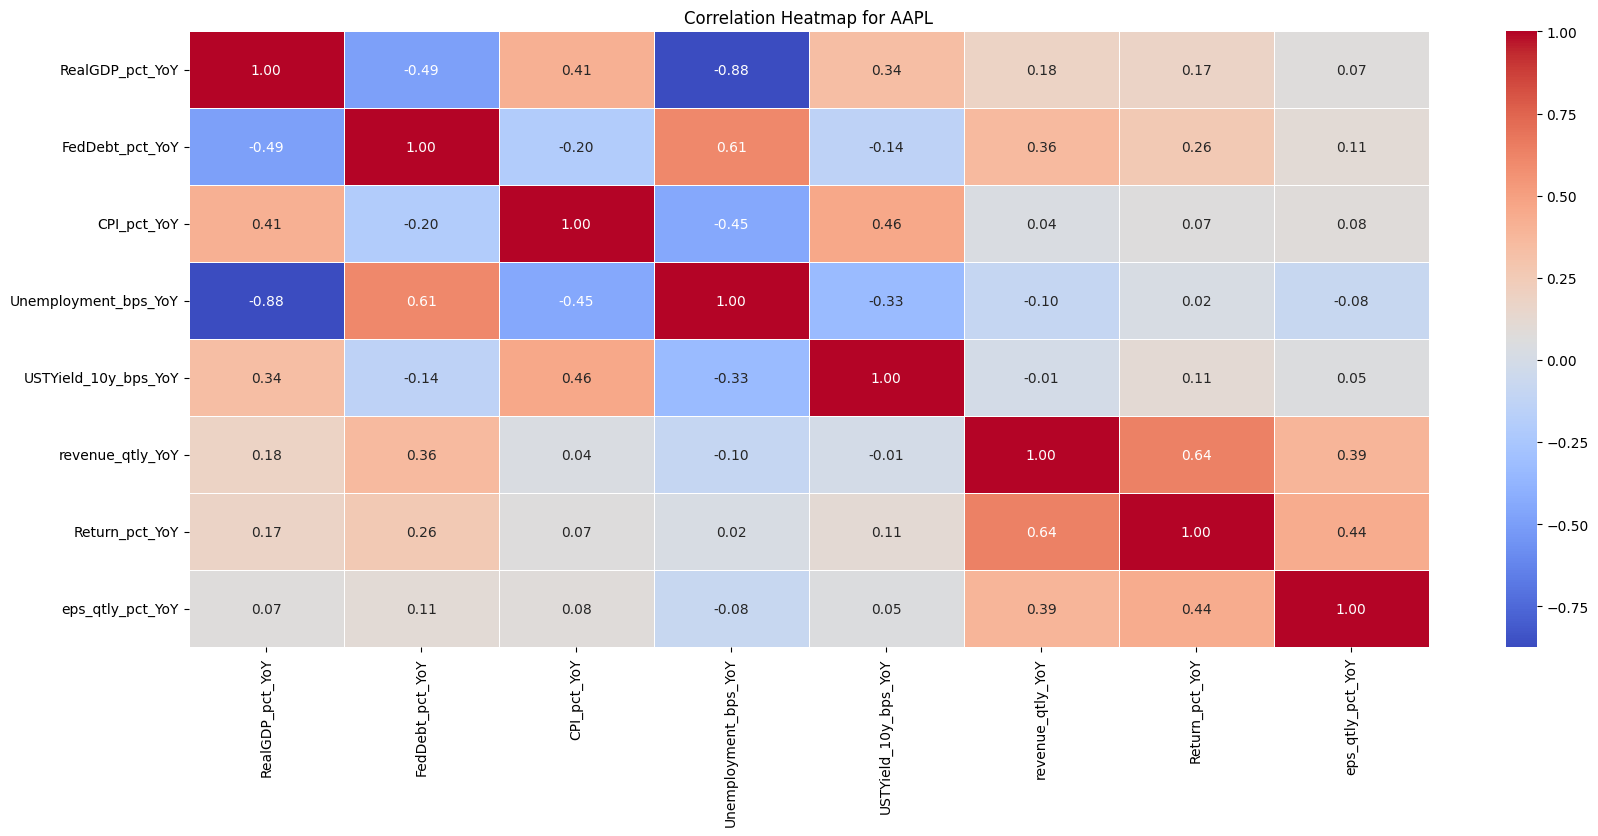

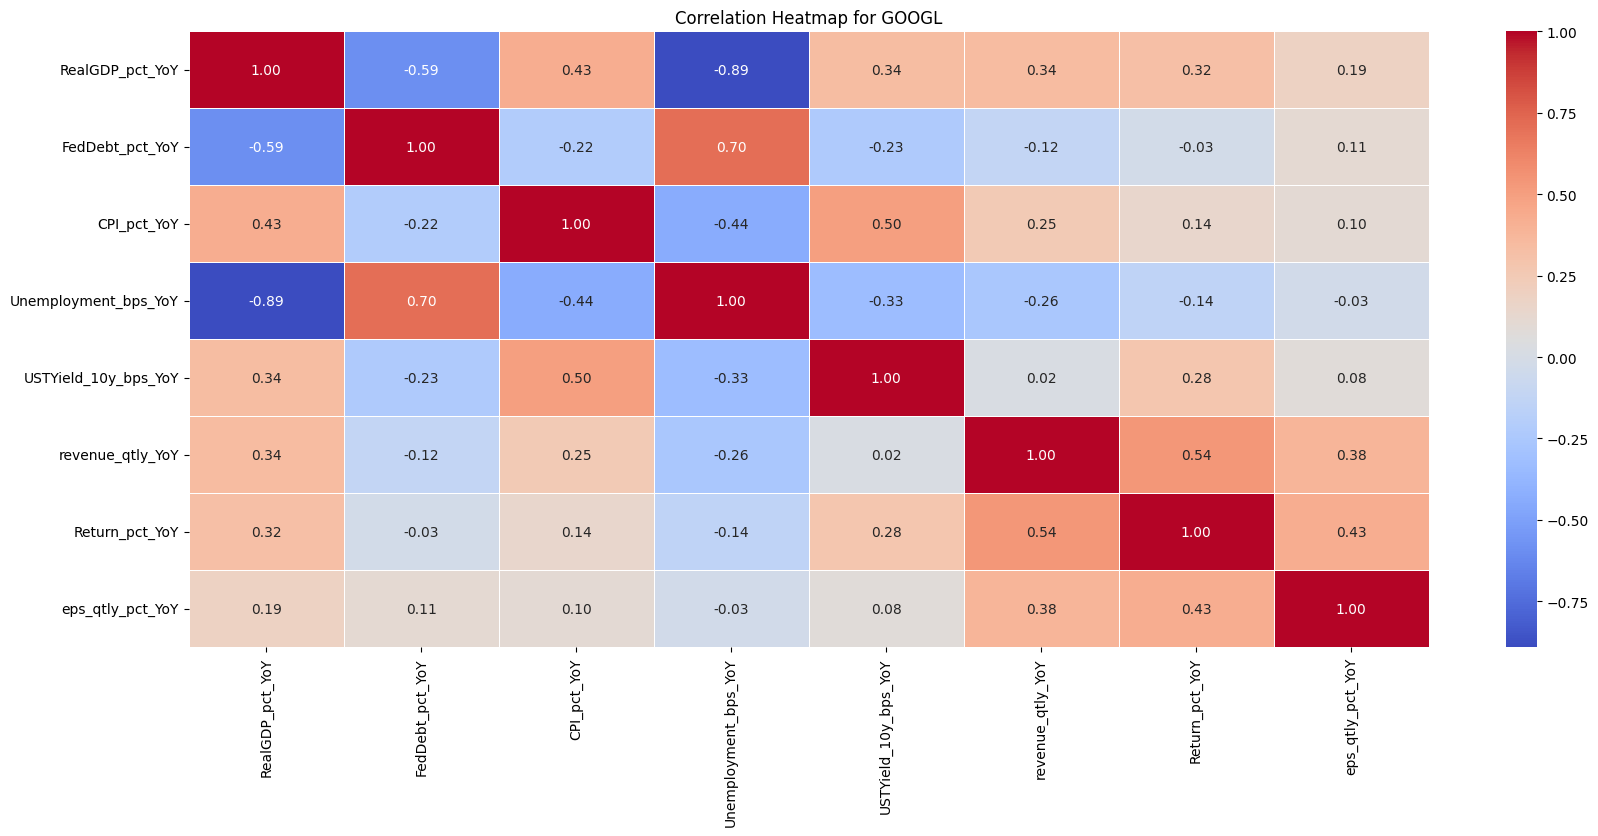

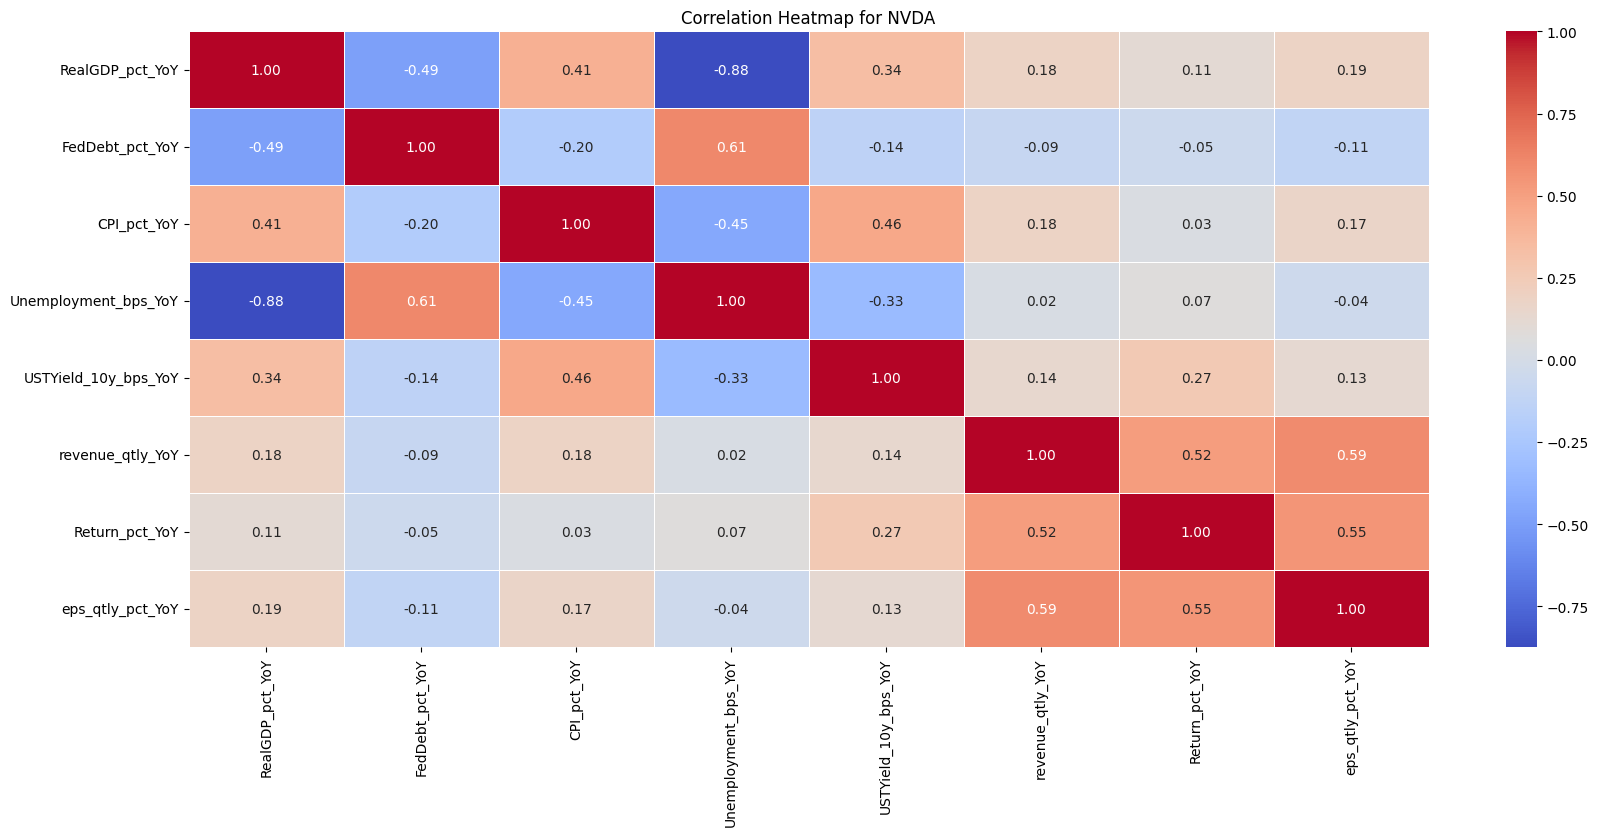

In [3]:
# Define the tickers and selected fields
tickers = ["AAPL", "GOOGL", "NVDA"]
fields = [
    "RealGDP_pct_YoY", "FedDebt_pct_YoY", "CPI_pct_YoY", "Unemployment_bps_YoY",
    "USTYield_10y_bps_YoY", "revenue_qtly_YoY", "Return_pct_YoY", "eps_qtly_pct_YoY"
]

# Convert field names to a consistent format (if needed)
df.columns = df.columns.str.strip()

# Create correlation heatmaps for each ticker
for ticker in tickers:
    df_ticker = df[df["symbol"] == ticker][fields].dropna()
    corr_matrix = df_ticker.corr()

    plt.figure(figsize=(20, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Heatmap for {ticker}")
    plt.show()

**Observations and Insights:**

1. Apple returns, revenue growth and EPS Growth have stronger correlation with Real GDP Growth, Federal Debt.

2. Google returns, revenue growth and EPS Growth have stronger correlation with Real GDP Growth, CPI Inflation.

3. Nvidia returns, revenue growth and EPS Growth have stronger correlation with Real GDP Growth, UST Yield Changes.

4. Stock returns for all 3 companies have the strongest correlation with their own revenue growth.

### Combined Correlation Heatmaps for All 3 Stocks

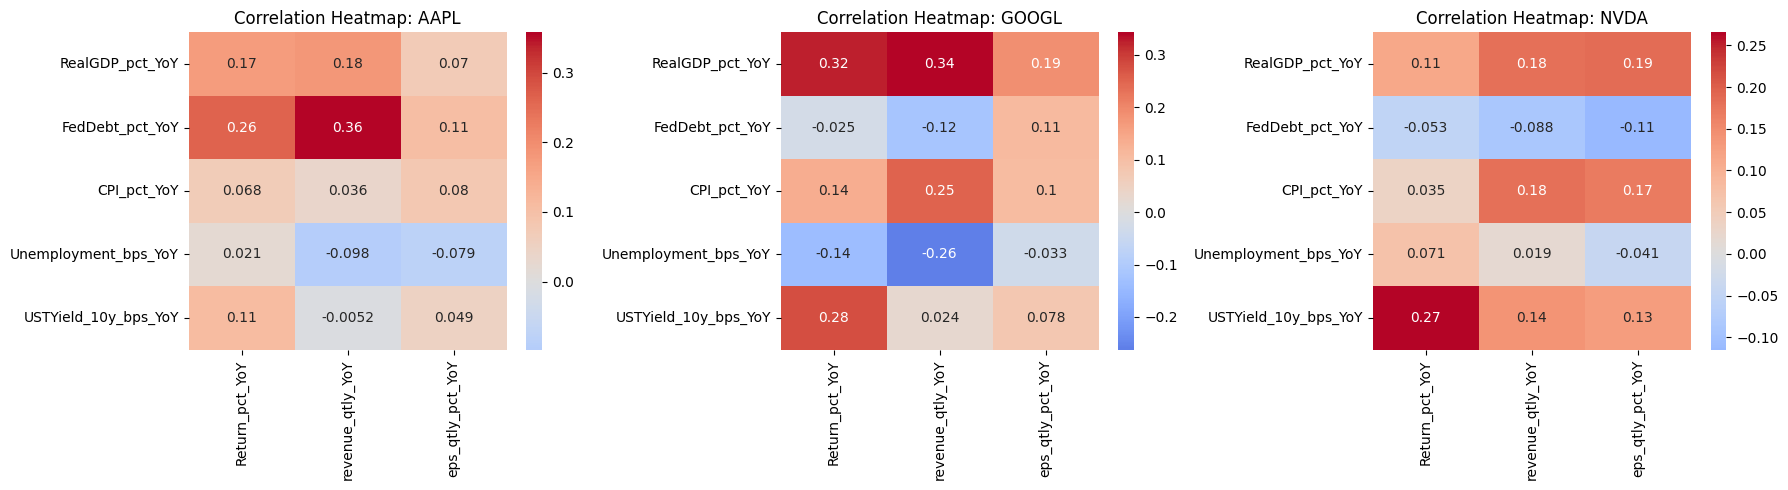

In [4]:
# Filter relevant stocks
selected_stocks = ["AAPL", "GOOGL", "NVDA"]
df_selected = df[df["symbol"].isin(selected_stocks)]

# Select key macroeconomic and financial metrics
macro_factors = [
    "RealGDP_pct_YoY", "FedDebt_pct_YoY", "CPI_pct_YoY",
    "Unemployment_bps_YoY", "USTYield_10y_bps_YoY"
]
financial_metrics = [
    "Return_pct_YoY", "revenue_qtly_YoY", "eps_qtly_pct_YoY"
]

# Compute correlation matrix between macro factors and financial metrics for each stock
correlations = {}
for stock in selected_stocks:
    df_stock = df_selected[df_selected["symbol"] == stock]
    corr_matrix = df_stock[macro_factors + financial_metrics].corr()
    correlations[stock] = corr_matrix.loc[macro_factors, financial_metrics]

# Convert to DataFrame for easier visualization
correlation_df = pd.concat(correlations, axis=1)

# Heatmaps - Side-by-side correlation matrices for each stock
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, stock in enumerate(selected_stocks):
    sns.heatmap(correlations[stock], annot=True, cmap="coolwarm", center=0, ax=axes[i])
    axes[i].set_title(f"Correlation Heatmap: {stock}")
plt.tight_layout()
plt.show()

**Observations and Insights:**

1. Correlation between macro indicators and stock returns, revenue growth and EPS growth are different for each of the 3 companies highlighting the underlying business model of each company. Apple - B2B, Google - B2B and B2C and
Nvidia - B2B

### Correlation Matrix Comparison between the 3 Stocks Returns vs Macro Economic Indicators and Revenue Growth

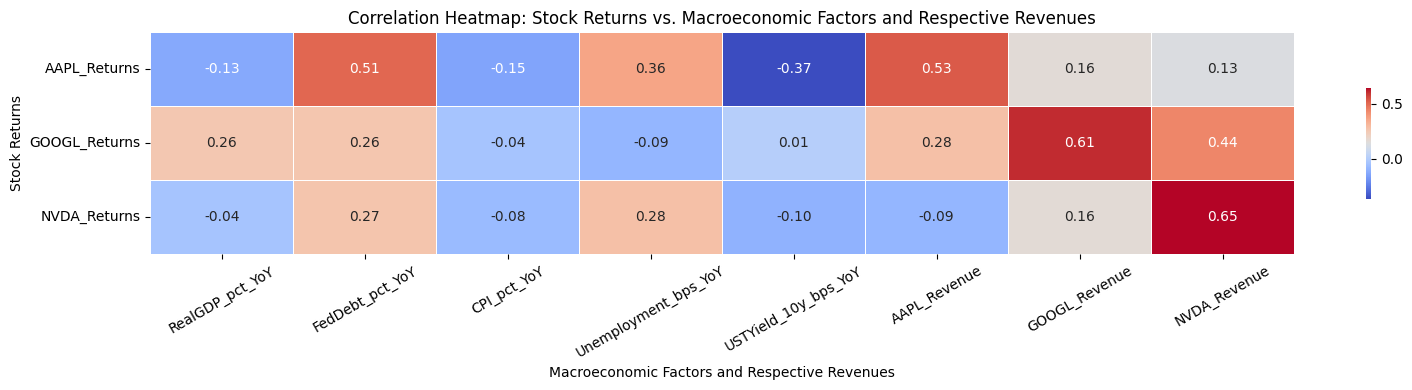

In [5]:
# Pivot the dataset to have AAPL, GOOGL, NVDA returns as separate columns
returns_df = df.pivot(index="date", columns="symbol", values="Return_pct_YoY")

# Pivot the dataset to have AAPL, GOOGL, NVDA revenues as separate columns
revenue_df = df.pivot(index="date", columns="symbol", values="revenue_qtly_YoY")

# Extract the macroeconomic variables
macro_factors = [
    "RealGDP_pct_YoY", "FedDebt_pct_YoY", "CPI_pct_YoY",
    "Unemployment_bps_YoY", "USTYield_10y_bps_YoY"
]

# Merge the macroeconomic variables back to returns and revenue data
merged_df = df.drop_duplicates(subset="date")[["date"] + macro_factors].merge(
    returns_df, on="date", how="inner"
).merge(
    revenue_df, on="date", how="inner"
)

# Rename columns for clarity
merged_df.rename(columns={
    "AAPL_x": "AAPL_Returns", "GOOGL_x": "GOOGL_Returns", "NVDA_x": "NVDA_Returns",
    "AAPL_y": "AAPL_Revenue", "GOOGL_y": "GOOGL_Revenue", "NVDA_y": "NVDA_Revenue"
}, inplace=True)

# Drop NaN values for correlation analysis
merged_df = merged_df.dropna()

# Compute correlation matrix
correlation_matrix = merged_df.corr()

# Extract the correlations of stock returns with macro factors and respective revenues
correlation_subset = correlation_matrix.loc[
    ["AAPL_Returns", "GOOGL_Returns", "NVDA_Returns"],
    macro_factors + ["AAPL_Revenue", "GOOGL_Revenue", "NVDA_Revenue"]
]

# Plot the correlation heatmap
plt.figure(figsize=(16, 4))
sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,cbar_kws={'shrink': 0.5})
plt.title("Correlation Heatmap: Stock Returns vs. Macroeconomic Factors and Respective Revenues")
plt.ylabel("Stock Returns")
plt.xlabel("Macroeconomic Factors and Respective Revenues")
plt.xticks(rotation=30)
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

**Observations:**
1. Stock Returns of each of the 3 companies have the highest correlation with their respective revenue growth

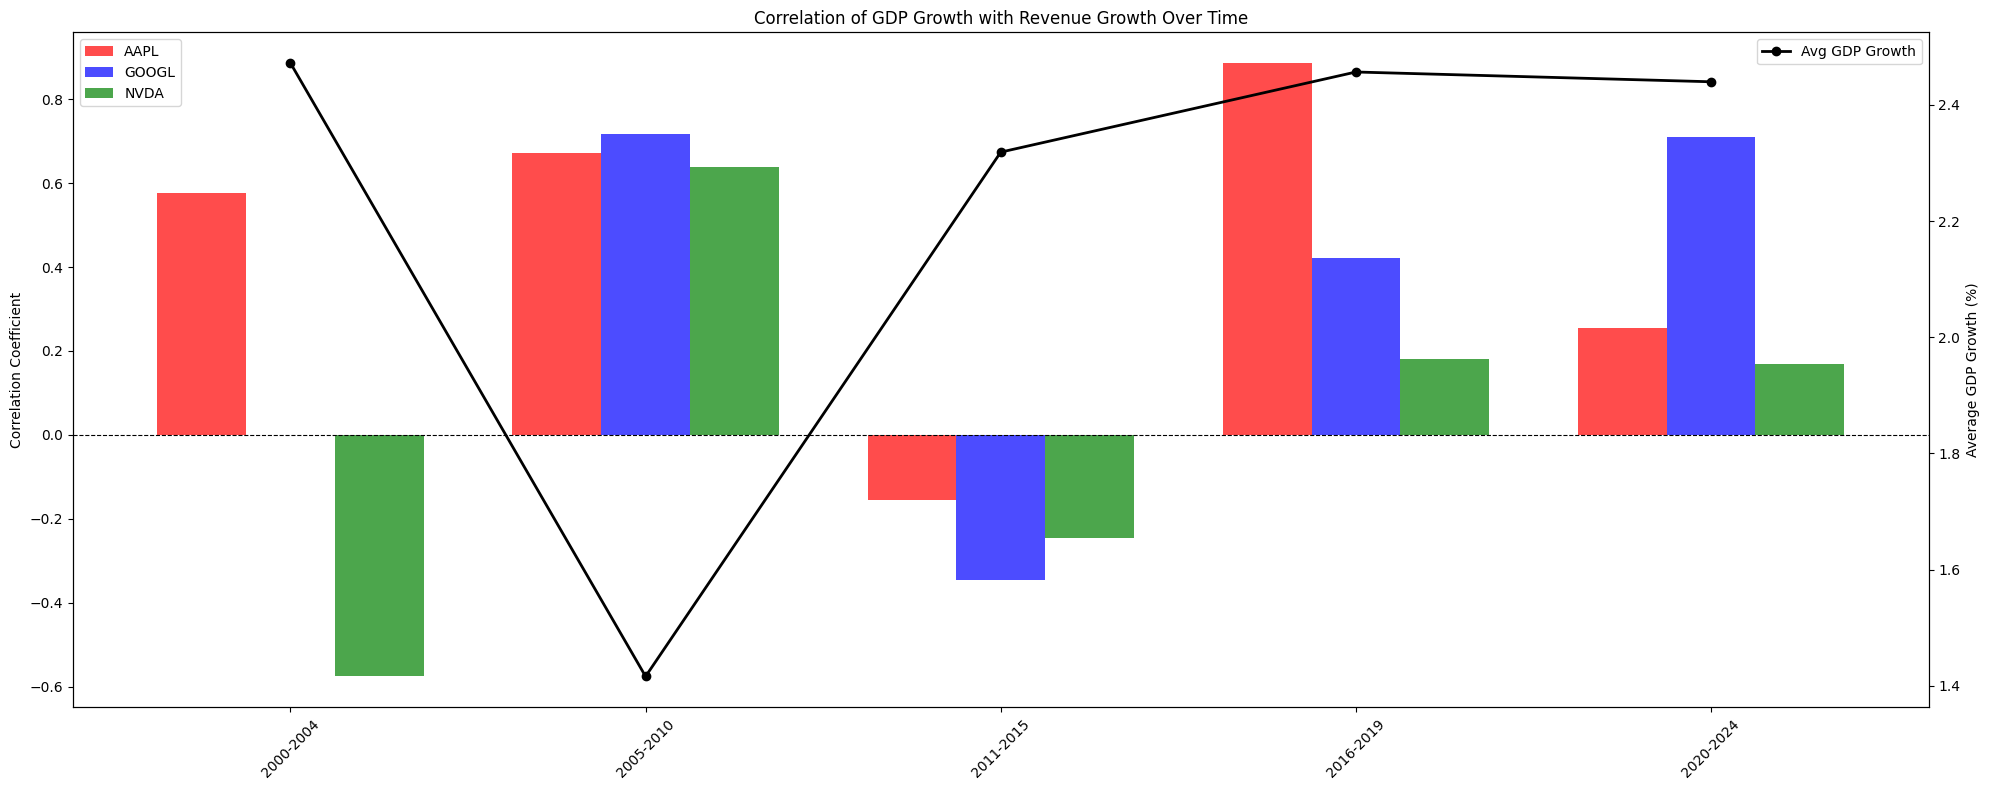

In [6]:
# Convert `date` column to datetime and extract year
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Define time periods
time_periods = {
    "2000-2004": (2000, 2004),
    "2005-2010": (2005, 2010),
    "2011-2015": (2011, 2015),
    "2016-2019": (2016, 2019),
    "2020-2024": (2020, 2024)
}

# Initialize dictionary to store correlations
correlations_gdp = {"AAPL": [], "GOOGL": [], "NVDA": []}
average_gdp_growth = []  # Store average GDP growth for each period

# Compute correlation of GDP with Revenue Growth across time periods
for period, (start, end) in time_periods.items():
    df_period = df[(df["year"] >= start) & (df["year"] <= end)]

    # Calculate average GDP growth for the period
    avg_gdp = df_period["RealGDP_pct_YoY"].mean()
    average_gdp_growth.append(avg_gdp)

    # Compute correlation for each stock
    for stock in ["AAPL", "GOOGL", "NVDA"]:
        stock_data = df_period[df_period["symbol"] == stock]
        correlation = stock_data["RealGDP_pct_YoY"].corr(stock_data["revenue_qtly_YoY"])
        correlations_gdp[stock].append(correlation)

# Convert correlation data into a DataFrame for visualization
corr_gdp_df = pd.DataFrame(correlations_gdp, index=time_periods.keys())

# Plot correlation trends using a bar chart with GDP growth as a line plot
fig, ax1 = plt.subplots(figsize=(20, 8))
bar_width = 0.25
x = range(len(time_periods.keys()))
colors = ["red", "blue", "green"]

# Plot correlation bars
for idx, (stock, color) in enumerate(zip(["AAPL", "GOOGL", "NVDA"], colors)):
    ax1.bar([i + (idx - 1) * bar_width for i in x], corr_gdp_df[stock], width=bar_width, label=stock, color=color, alpha=0.7)

# Add GDP growth as a line plot on a secondary axis
ax2 = ax1.twinx()
ax2.plot(x, average_gdp_growth, marker="o", color="black", linestyle="-", linewidth=2, label="Avg GDP Growth")

# Labels and Titles
ax1.set_title("Correlation of GDP Growth with Revenue Growth Over Time")
ax1.set_ylabel("Correlation Coefficient")
ax2.set_ylabel("Average GDP Growth (%)")

ax1.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(time_periods.keys(), rotation=45)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.xlabel("Time Periods")
plt.tight_layout()
plt.show()

**Note:**
 - X-axis represents the different time periods

 - Dual Y-axis:

  1. left measures the correlation coefficient and

  2. right measures the average GDP growth (in %)

 - Correlation coefficient is between revenue growth and GDP growth

**Observation and Insights:**

1. Google's revenue growth follows the GDP growth trend

2. Apple and Nvidia's revenue growth is independant of GDP growth aligning with their unique markets

## Regression Analysis - Macros

### Can macro economic indicators predict stock returns or revenue changes

#### Regression for Apple Revenue Growth

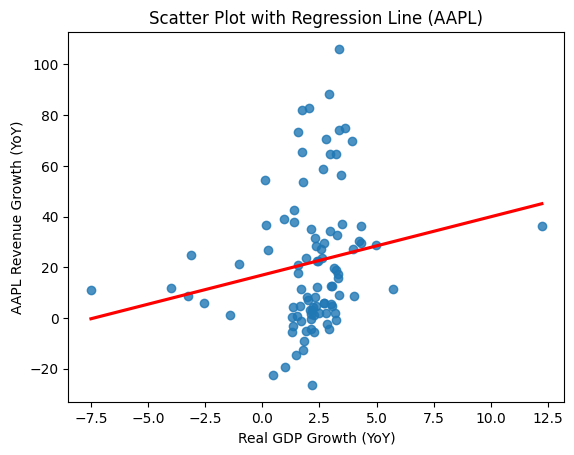

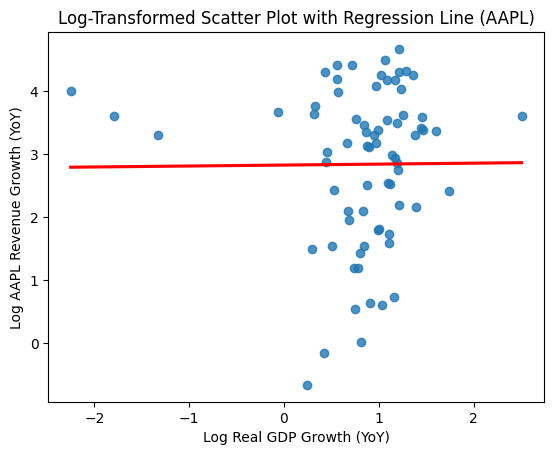

In [7]:
# Selecting relevant variables for Apple (AAPL)
df_aapl = df[df['symbol'] == 'AAPL'][['RealGDP_pct_YoY', 'revenue_qtly_YoY']].dropna()

# Checking for linearity with scatter plot
sns.regplot(x=df_aapl['RealGDP_pct_YoY'], y=df_aapl['revenue_qtly_YoY'], ci=None, line_kws={"color": "red"})
plt.xlabel("Real GDP Growth (YoY)")
plt.ylabel("AAPL Revenue Growth (YoY)")
plt.title("Scatter Plot with Regression Line (AAPL)")
plt.show()

# Filtering out negative values to allow log transformation
df_aapl = df_aapl[(df_aapl['RealGDP_pct_YoY'] > 0) & (df_aapl['revenue_qtly_YoY'] > 0)]

# Applying log transformation
df_aapl['log_revenue'] = np.log(df_aapl['revenue_qtly_YoY'])
df_aapl['log_gdp'] = np.log(df_aapl['RealGDP_pct_YoY'])

# Scatter plot after filtering and log transformation
sns.regplot(x=df_aapl['log_gdp'], y=df_aapl['log_revenue'], ci=None, line_kws={"color": "red"})
plt.xlabel("Log Real GDP Growth (YoY)")
plt.ylabel("Log AAPL Revenue Growth (YoY)")
plt.title("Log-Transformed Scatter Plot with Regression Line (AAPL)")
plt.show()

OLS Regression Model Summary (AAPL):
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                 0.0004270
Date:                Sun, 23 Feb 2025   Prob (F-statistic):              0.984
Time:                        12:56:28   Log-Likelihood:                -93.890
No. Observations:                  57   AIC:                             191.8
Df Residuals:                      55   BIC:                             195.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

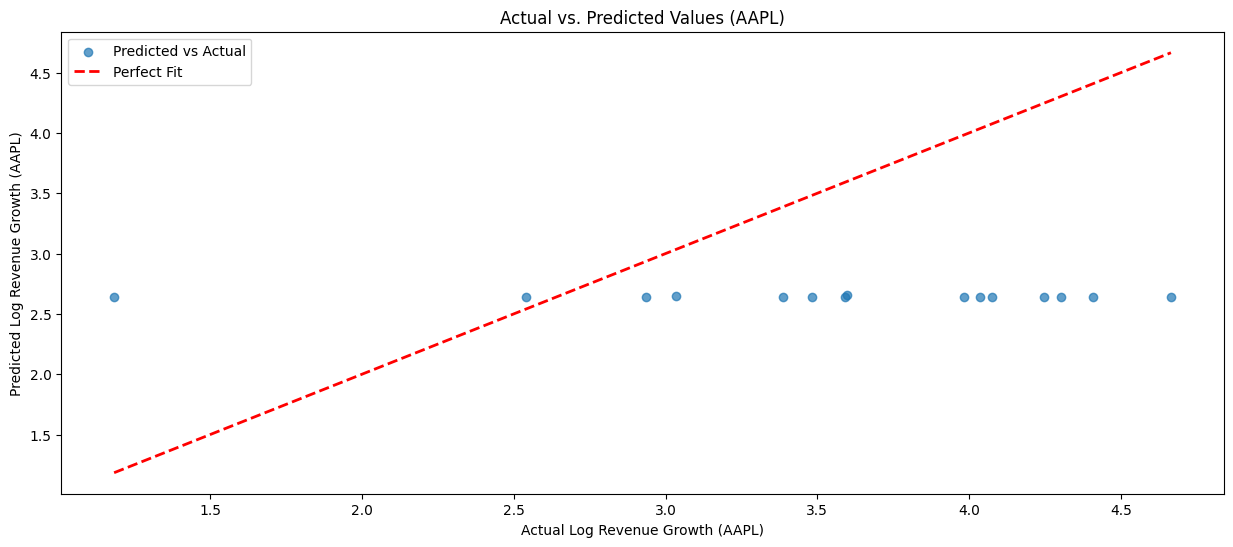

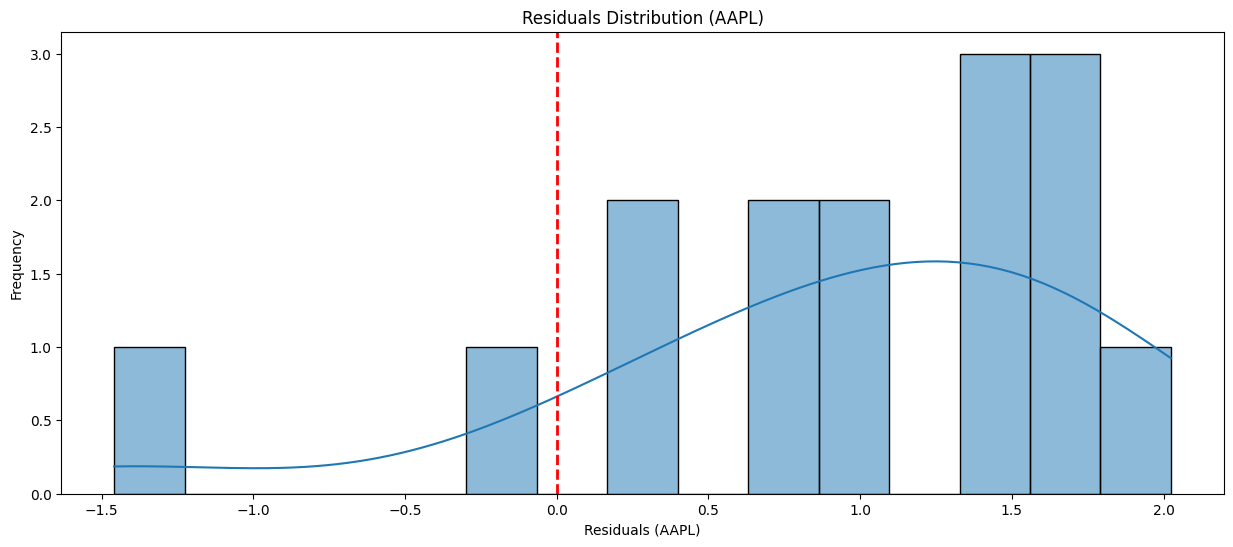

In [8]:
# Splitting the data into training and testing sets
X_aapl = df_aapl[['log_gdp']]
y_aapl = df_aapl['log_revenue']

X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(
    X_aapl, y_aapl, test_size=0.2, random_state=42
)

# Adding constant for OLS regression
X_train_aapl_const = sm.add_constant(X_train_aapl)
X_test_aapl_const = sm.add_constant(X_test_aapl)

# Fitting OLS regression model
model_aapl = sm.OLS(y_train_aapl, X_train_aapl_const).fit()

# Predicting on test set
y_pred_aapl = model_aapl.predict(X_test_aapl_const)

# Performance metrics
mae_aapl = mean_absolute_error(y_test_aapl, y_pred_aapl)
mse_aapl = mean_squared_error(y_test_aapl, y_pred_aapl)
rmse_aapl = np.sqrt(mse_aapl)
r2_aapl = r2_score(y_test_aapl, y_pred_aapl)

# Displaying results
print("OLS Regression Model Summary (AAPL):")
print(model_aapl.summary())

print("\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_aapl:.4f}")
print(f"Mean Squared Error (MSE): {mse_aapl:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_aapl:.4f}")
print(f"R-squared (R²): {r2_aapl:.4f}")

# Plotting actual vs. predicted values
plt.figure(figsize=(15, 6))
plt.scatter(y_test_aapl, y_pred_aapl, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test_aapl.min(), y_test_aapl.max()], [y_test_aapl.min(), y_test_aapl.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Log Revenue Growth (AAPL)")
plt.ylabel("Predicted Log Revenue Growth (AAPL)")
plt.title("Actual vs. Predicted Values (AAPL)")
plt.legend()
plt.show()

# Plotting residuals
residuals_aapl = y_test_aapl - y_pred_aapl

plt.figure(figsize=(15, 6))
sns.histplot(residuals_aapl, bins=15, kde=True)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Residuals (AAPL)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (AAPL)")
plt.show()

**Observation and Insight:**

1. Negative R squared indicates poor model perfomance. GDP growth is not a good predictor of revenue growth

#### Regression for Google Revenue Growth

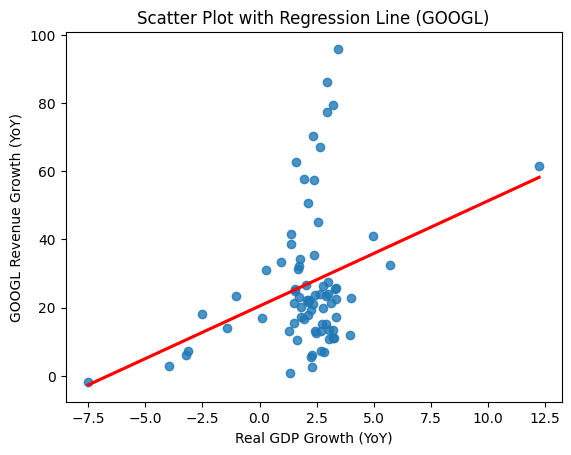

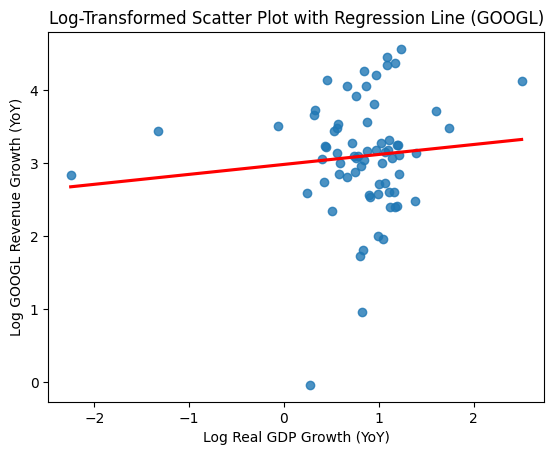

In [9]:
# Selecting relevant variables for Google (GOOGL)
df_google = df[df['symbol'] == 'GOOGL'][['RealGDP_pct_YoY', 'revenue_qtly_YoY']].dropna()

# Checking for linearity with scatter plot
sns.regplot(x=df_google['RealGDP_pct_YoY'], y=df_google['revenue_qtly_YoY'], ci=None, line_kws={"color": "red"})
plt.xlabel("Real GDP Growth (YoY)")
plt.ylabel("GOOGL Revenue Growth (YoY)")
plt.title("Scatter Plot with Regression Line (GOOGL)")
plt.show()

# Filtering out negative values to allow log transformation
df_google = df_google[(df_google['RealGDP_pct_YoY'] > 0) & (df_google['revenue_qtly_YoY'] > 0)]

# Applying log transformation
df_google['log_revenue'] = np.log(df_google['revenue_qtly_YoY'])
df_google['log_gdp'] = np.log(df_google['RealGDP_pct_YoY'])

# Scatter plot after filtering and log transformation
sns.regplot(x=df_google['log_gdp'], y=df_google['log_revenue'], ci=None, line_kws={"color": "red"})
plt.xlabel("Log Real GDP Growth (YoY)")
plt.ylabel("Log GOOGL Revenue Growth (YoY)")
plt.title("Log-Transformed Scatter Plot with Regression Line (GOOGL)")
plt.show()

OLS Regression Model Summary (GOOGL):
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.202
Date:                Sun, 23 Feb 2025   Prob (F-statistic):              0.278
Time:                        12:56:29   Log-Likelihood:                -65.277
No. Observations:                  56   AIC:                             134.6
Df Residuals:                      54   BIC:                             138.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

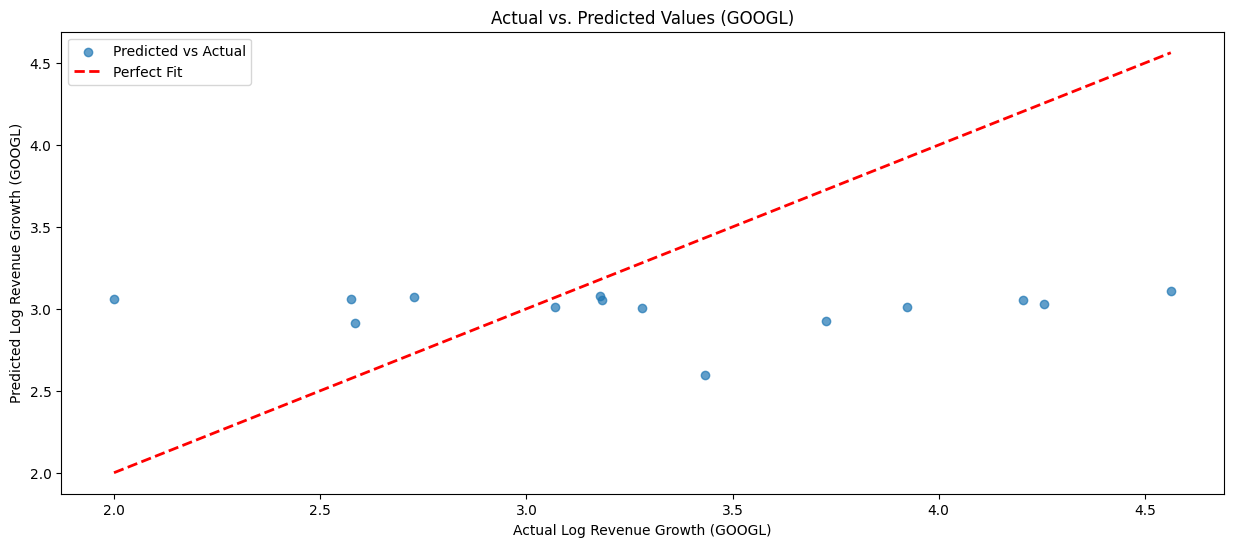

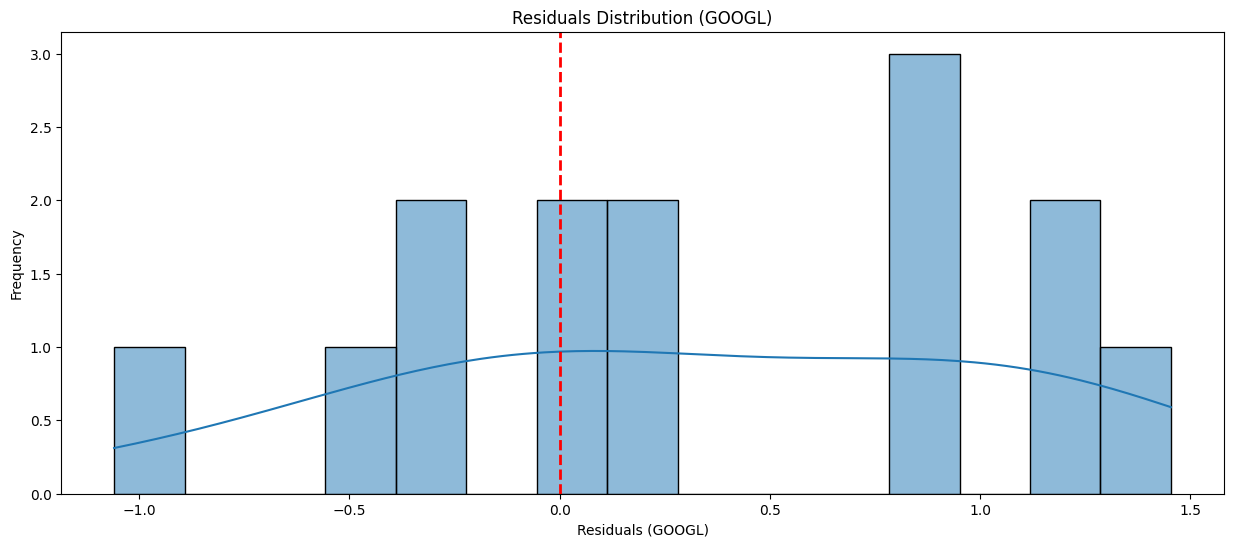

In [10]:
# Splitting the data into training and testing sets
X_google = df_google[['log_gdp']]
y_google = df_google['log_revenue']

X_train_google, X_test_google, y_train_google, y_test_google = train_test_split(
    X_google, y_google, test_size=0.2, random_state=42
)

# Adding constant for OLS regression
X_train_google_const = sm.add_constant(X_train_google)
X_test_google_const = sm.add_constant(X_test_google)

# Fitting OLS regression model
model_google = sm.OLS(y_train_google, X_train_google_const).fit()

# Predicting on test set
y_pred_google = model_google.predict(X_test_google_const)

# Performance metrics
mae_google = mean_absolute_error(y_test_google, y_pred_google)
mse_google = mean_squared_error(y_test_google, y_pred_google)
rmse_google = np.sqrt(mse_google)
r2_google = r2_score(y_test_google, y_pred_google)

# Displaying results
print("OLS Regression Model Summary (GOOGL):")
print(model_google.summary())

print("\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_google:.4f}")
print(f"Mean Squared Error (MSE): {mse_google:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_google:.4f}")
print(f"R-squared (R²): {r2_google:.4f}")

# Plotting actual vs. predicted values
plt.figure(figsize=(15, 6))
plt.scatter(y_test_google, y_pred_google, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test_google.min(), y_test_google.max()], [y_test_google.min(), y_test_google.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Log Revenue Growth (GOOGL)")
plt.ylabel("Predicted Log Revenue Growth (GOOGL)")
plt.title("Actual vs. Predicted Values (GOOGL)")
plt.legend()
plt.show()

# Plotting residuals
residuals_google = y_test_google - y_pred_google

plt.figure(figsize=(15, 6))
sns.histplot(residuals_google, bins=15, kde=True)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Residuals (GOOGL)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (GOOGL)")
plt.show()

**Observation and Insight:**

1. Negative R squared indicates poor model perfomance. GDP growth is not a good predictor of revenue growth

#### Regression for Nvidia Revenue Growth

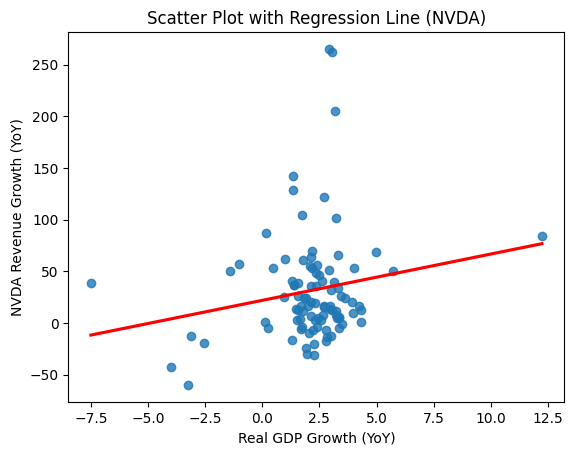

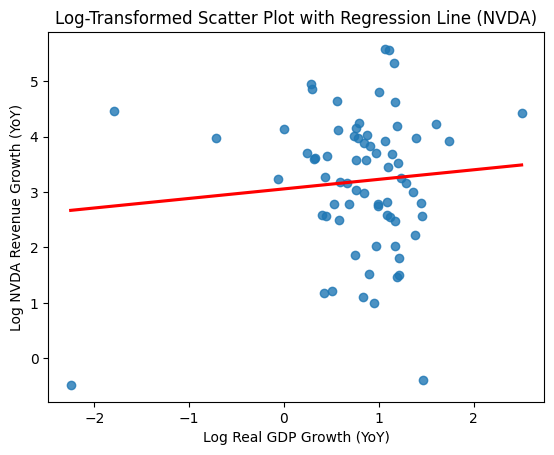

In [11]:
# Selecting relevant variables for NVIDIA (NVDA)
df_nvda = df[df['symbol'] == 'NVDA'][['RealGDP_pct_YoY', 'revenue_qtly_YoY']].dropna()

# Checking for linearity with scatter plot
sns.regplot(x=df_nvda['RealGDP_pct_YoY'], y=df_nvda['revenue_qtly_YoY'], ci=None, line_kws={"color": "red"})
plt.xlabel("Real GDP Growth (YoY)")
plt.ylabel("NVDA Revenue Growth (YoY)")
plt.title("Scatter Plot with Regression Line (NVDA)")
plt.show()

# Filtering out negative values to allow log transformation
df_nvda = df_nvda[(df_nvda['RealGDP_pct_YoY'] > 0) & (df_nvda['revenue_qtly_YoY'] > 0)]

# Applying log transformation
df_nvda['log_revenue'] = np.log(df_nvda['revenue_qtly_YoY'])
df_nvda['log_gdp'] = np.log(df_nvda['RealGDP_pct_YoY'])

# Scatter plot after filtering and log transformation
sns.regplot(x=df_nvda['log_gdp'], y=df_nvda['log_revenue'], ci=None, line_kws={"color": "red"})
plt.xlabel("Log Real GDP Growth (YoY)")
plt.ylabel("Log NVDA Revenue Growth (YoY)")
plt.title("Log-Transformed Scatter Plot with Regression Line (NVDA)")
plt.show()

OLS Regression Model Summary (NVDA):
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.226
Date:                Sun, 23 Feb 2025   Prob (F-statistic):              0.142
Time:                        12:56:30   Log-Likelihood:                -88.684
No. Observations:                  56   AIC:                             181.4
Df Residuals:                      54   BIC:                             185.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

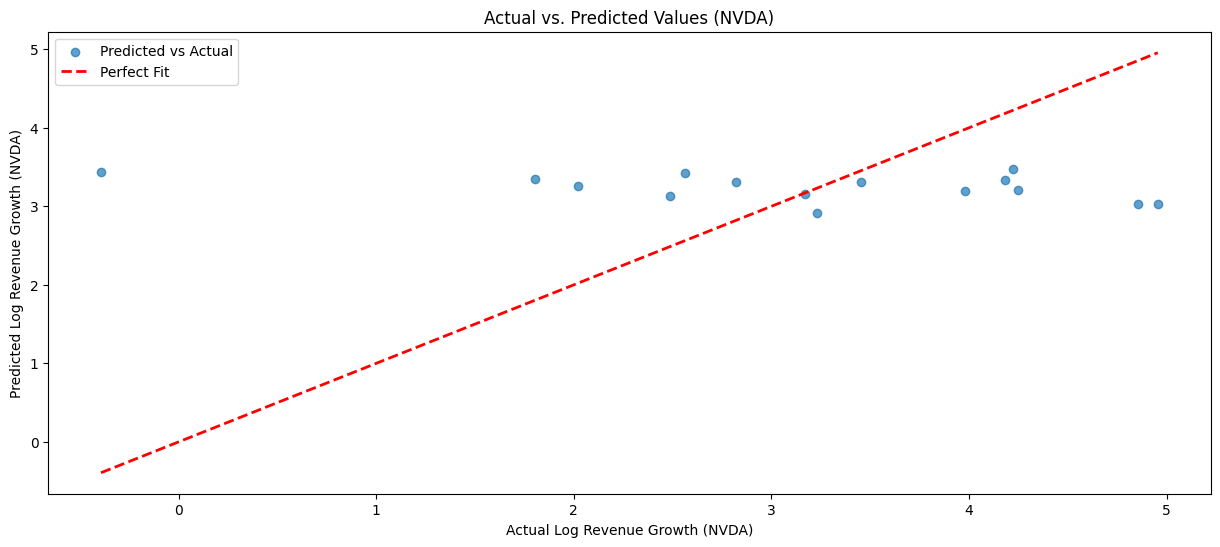

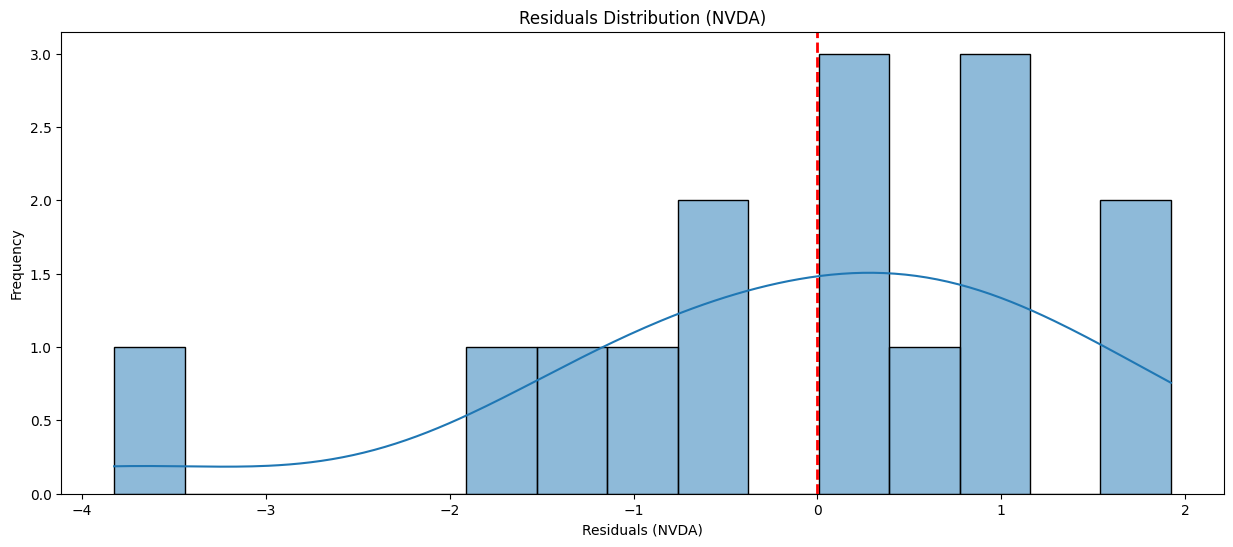

In [12]:
# Splitting the data into training and testing sets
X_nvda = df_nvda[['log_gdp']]
y_nvda = df_nvda['log_revenue']

X_train_nvda, X_test_nvda, y_train_nvda, y_test_nvda = train_test_split(
    X_nvda, y_nvda, test_size=0.2, random_state=42
)

# Adding constant for OLS regression
X_train_nvda_const = sm.add_constant(X_train_nvda)
X_test_nvda_const = sm.add_constant(X_test_nvda)

# Fitting OLS regression model
model_nvda = sm.OLS(y_train_nvda, X_train_nvda_const).fit()

# Predicting on test set
y_pred_nvda = model_nvda.predict(X_test_nvda_const)

# Performance metrics
mae_nvda = mean_absolute_error(y_test_nvda, y_pred_nvda)
mse_nvda = mean_squared_error(y_test_nvda, y_pred_nvda)
rmse_nvda = np.sqrt(mse_nvda)
r2_nvda = r2_score(y_test_nvda, y_pred_nvda)

# Displaying results
print("OLS Regression Model Summary (NVDA):")
print(model_nvda.summary())

print("\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_nvda:.4f}")
print(f"Mean Squared Error (MSE): {mse_nvda:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_nvda:.4f}")
print(f"R-squared (R²): {r2_nvda:.4f}")

# Plotting actual vs. predicted values
plt.figure(figsize=(15, 6))
plt.scatter(y_test_nvda, y_pred_nvda, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test_nvda.min(), y_test_nvda.max()], [y_test_nvda.min(), y_test_nvda.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Log Revenue Growth (NVDA)")
plt.ylabel("Predicted Log Revenue Growth (NVDA)")
plt.title("Actual vs. Predicted Values (NVDA)")
plt.legend()
plt.show()

# Plotting residuals
residuals_nvda = y_test_nvda - y_pred_nvda

plt.figure(figsize=(15, 6))
sns.histplot(residuals_nvda, bins=15, kde=True)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Residuals (NVDA)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (NVDA)")
plt.show()

**Observation and Insight:**

1. Negative R squared indicates poor model perfomance. GDP growth is not a good predictor of revenue growth

# EDA - Earnings

## Setup - Earnings

### Import libraries and set settings

In [13]:
# essentials
import pandas as pd
import numpy as np

# stat analysis
import statistics as st
from scipy import stats
from scipy.stats import skew
from scipy.spatial.distance import cdist

# predictive modelling
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from catboost import CatBoostRegressor, Pool, cv

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Other
import warnings

In [14]:
# suppress all warning notifications
#warnings.filterwarnings('ignore')

In [15]:
# disable scientific notation
np.set_printoptions(suppress=True)

# display all numeric values in the DataFrame in standard numeric format
pd.set_option('display.float_format', '{:.2f}'.format)

In [16]:
# set theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.bottom":True}
sns.set_theme(style="white", rc=custom_params)

###  User-defined functions

In [17]:
# returns a summary of the goodness of fit metrics for a model.
def goodness_of_fit(y, y_pred, model, model_name_str):
    df = pd.DataFrame({'R2': [metrics.r2_score(y, y_pred)]})
#    try:
#        df['R2 (train)'] = model.rsquared
#    except AttributeError:
#        df['R2 (train)'] = None
#    try:
#        df['Adj. R2 (train)'] = model.rsquared_adj
#    except AttributeError:
#        df['Adj. R2 (train)'] = None
    df['RMSE'] = np.sqrt(metrics.mean_squared_error(y, y_pred))
    df['MAE'] = metrics.mean_absolute_error(y, y_pred)
    df['1st Quartile (y_real)'] = np.percentile(y, 25)
    df['3rd Quartile (y_real)'] = np.percentile(y, 75)
    df['Mean (y_real)'] = y.mean()
    df = df.T
    df.columns = [model_name_str]
    return df

In [18]:
# a function to check if a variable is defined
# takes variable's name as a string and returns a boolean value
def check_variable(var_name):
    try:
        if var_name in globals():
            return True
        else:
            return False
    except NameError:
        return False

In [19]:
# Function to detect outliers using a specified method
def count_outliers(series, method="IQR"):
    """
    Count outliers in a series based on the selected method.

    Parameters:
    - series: pandas Series
    - method: str, one of ["IQR", "Tukey", "Three-Sigma"]

    Returns:
    - int: number of outliers
    """
    if method == "IQR":
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    elif method == "Tukey":
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
    elif method == "Three-Sigma":
        mean = series.mean()
        std = series.std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
    else:
        raise ValueError("Invalid method. Choose from 'IQR', 'Tukey's', or 'Three-Sigma'.")

    return ((series < lower_bound) | (series > upper_bound)).sum()

In [20]:
# Function to create a descriptive statistics summary for a DataFrame
def desc_stat_summary(df):
    numeric_df = df.select_dtypes(include=['number']).copy()
    summary = numeric_df.describe().T
    summary['Range'] = summary['max'] - summary['min']
    summary['IQR'] = summary['75%'] - summary['25%']
    summary['Skewness (n=0)'] = numeric_df.apply(lambda x: stats.skew(x, nan_policy='omit'))
    summary['Kurtosis (n=3)'] = numeric_df.apply(lambda x: stats.kurtosis(x, nan_policy='omit', fisher=False))
    summary['Shapiro-Wilk, stat (n=1)'] = numeric_df.apply(lambda x: stats.shapiro(x, nan_policy='omit')[0])
    summary['Shapiro-Wilk, p-value (>0.05)'] = numeric_df.apply(lambda x: stats.shapiro(x, nan_policy='omit')[1])

    # Outlier detection for different methods
    summary['Outliers (IQR)'] = numeric_df.apply(lambda x: count_outliers(x, method="IQR"))
    summary['Outliers (Tukey)'] = numeric_df.apply(lambda x: count_outliers(x, method="Tukey"))
    summary['Outliers (Three-Sigma)'] = numeric_df.apply(lambda x: count_outliers(x, method="Three-Sigma"))

    return summary

In [21]:
def evaluate_performance(y, y_pred, model, test_type, model_id):
    """
    Evaluates model performance and updates/initiates the global gof_summary.

    Parameters:
    y (pd.Series or np.array): True values.
    y_pred (pd.Series or np.array): Predicted values.
    model: Model used for prediction.
    test_type (str): Indicates whether evaluation is for 'train' or 'test'.
    model_id (str): Identifier for the model.
    """
    global gof_summary
    gof_result = goodness_of_fit(y.values, y_pred, model, f'{model_id}_{test_type}')

    if check_variable('gof_summary'):
        gof_summary = gof_summary.merge(gof_result, left_index=True, right_index=True)
    else:
        gof_summary = gof_result

In [22]:
def correlation_analysis(df, target_variable, category, sample_desc, method='pearson', export=False):
	"""
	Computes correlation between the target variable and other numerical features, grouped by a specified category,
	and visualises the results in a heatmap.

	Parameters:
	df (pd.DataFrame): The input DataFrame containing market data.
	target_variable (str): The target variable for correlation analysis.
	category (str): The name of the column to group by (e.g., 'ticker').
	sample_desc (str): The description of sample to be used in file names and plot titles.
	method (str): Correlation method, ['pearson', 'kendall', 'spearman'} default is 'pearson'.
	export (bool): If True, exports correlation_summary_df to CSV and saves the heatmap plot as PNG.

	Returns:
	matplotlib.axes._subplots.AxesSubplot: The heatmap object.
	"""
	correlation_summary = []

	categories = df[category].unique()

	# Correlation by individual category
	for cat in categories:
		corr_df = df[df[category] == cat].corr(method=method, numeric_only=True)[[target_variable]]
		corr_df.columns = [f'{cat}']
		correlation_summary.append(corr_df)

	# Correlation for the full dataset
	corr_df = df.corr(method=method, numeric_only=True)[[target_variable]]
	corr_df.columns = [f'All {category.capitalize()}s']
	correlation_summary.append(corr_df)

	# Merge results into a single DataFrame & drop redundant records
	correlation_summary_df = pd.concat(correlation_summary, axis=1)
	correlation_summary_df = correlation_summary_df.drop(index=target_variable, errors='ignore')

	# Plot heatmap
	plt.figure(figsize=(5, 6))
	ax = sns.heatmap(correlation_summary_df, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 11})

	# Reduce font size of tick labels
	plt.xticks(fontsize=9)
	plt.yticks(fontsize=9)

	plt.title(f'{method.capitalize()} correlation of {target_variable} by {category.capitalize()}s ({sample_desc})\n\n', fontsize=12)
	ax.set(xlabel='', ylabel='Features')
	ax.xaxis.tick_top()

	# Export data and plot if enabled
	if export:
		csv_filename = f'Corr_{target_variable}__{category}_{sample_desc}_{method}.csv'
		png_filename = f'Corr_{target_variable}__{category}_{sample_desc}_{method}.png'
		correlation_summary_df.to_csv(csv_filename)
		plt.savefig(png_filename, bbox_inches='tight', dpi=300)

	return ax


In [23]:
def plot_variable_distribution(df, variables, date_column):
    """
    Plots histograms, boxplots, and time series line plots for numerical columns in a DataFrame.

    Parameters:
    - df: pandas DataFrame with numerical values.
    - variables: List of column names to analyse.
    - date_column: Name of the column to use as x-axis in the line plot.
    """
    # Ensure only selected variables are in the dataframe
    df_selected = df[variables]

    num_features = len(variables)
    colors = sns.husl_palette(num_features, h=.5)

    fig, axes = plt.subplots(nrows=2, ncols=num_features, figsize=(5 * num_features, 5),
                             gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle('Distribution Analysis')

    # Ensure axes are iterable even for a single column
    if num_features == 1:
        axes = [[axes[0]], [axes[1]]]

    for i, (col, color) in enumerate(zip(variables, colors)):
        variable = df[col]
        var_min, var_max = variable.min(), variable.max()
        range_limit = (var_min, var_max)

        # Histogram with matching colour
        hist_ax = axes[0][i]
        sns.histplot(variable, bins=30, ax=hist_ax, color=color, alpha=0.7)
        hist_ax.set(yticks=[], xlabel='', ylabel='')
        hist_ax.set_title(f'{col}\n\n')

        # Make x-axis labels white
        hist_ax.tick_params(axis='x', colors='white')

        # Add vertical line at zero if within range
        if var_min <= 0 <= var_max:
            hist_ax.axvline(0, color='black', linestyle='--', linewidth=1.5)

        # Boxplot with matching colour
        box_ax = axes[1][i]
        sns.boxplot(x=variable, ax=box_ax, color=color, orient='h', width=0.5)
        box_ax.set(xlabel=col, yticks=[])

        # Set x-axis limits of the boxplot to match the histogram
        box_ax.set_xlim(hist_ax.get_xlim())

    plt.tight_layout()
    plt.show()

    # Line Plot for Time Series Data
    plt.figure(figsize=(12, 2.5))

    for col, color in zip(variables, colors):
        sns.lineplot(x=df[date_column], y=df[col], label=col, color=color)

    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Add title and legend
    plt.title(f'\n\nVariability Analysis\n\n')
    plt.legend(loc='center left', bbox_to_anchor=(1, 1))  # Move legend to the right

    plt.show()


In [24]:
def plot_predictions_vs_observations(y_true, y_pred, model_id, set_type):
    """
    Plots predictions vs. observations for a given dataset.

    Parameters:
    y_true (pd.Series or np.array): True values.
    y_pred (pd.Series or np.array): Predicted values.
    model_id (str): Identifier for the model.
    set_type (str): Indicates whether evaluation is for 'train' or 'test'.
    """
    X_var = y_true.squeeze()
    Y_var = pd.Series(y_pred)

    lim = max(abs(X_var).max(), abs(Y_var).max()) * 1.1

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(X_var, Y_var, color='red')

    # Add a diagonal line
    plt.axline((0, 0), slope=1, color='green')

    # Add horizontal and vertical reference lines
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

    # Set x and y axis limits
    ax.set_xlim(-lim * (X_var.min() < 0), lim * (X_var.max() > 0))
    ax.set_ylim(-lim * (Y_var.min() < 0), lim * (Y_var.max() > 0))

    # Add labels & title
    ax.set_xlabel(f'Observations ({set_type})')
    ax.set_ylabel(f'Predictions ({set_type})')
    ax.set_title(f'{model_id}: Predictions vs. observations ({set_type})')

    plt.show()

### Import data

In [25]:
# import
earnings_data = pd.read_csv('earnings_dataset_export.csv')

## Wrangling and Transformation - Earnings

### Filter earnings data for AAPL, GOOGL and NVDA

<div style="
    background-color: #fffbea;
    border: 1px solid #f0e68c;
    border-left: 20px solid #ffd700;
    border-radius: 4px;
    padding: 10px;
    margin: 10px 0;
    font-family: Calibri, sans-serif;
    font-size: 16px;
    font-weight: 400;
    color: #333;">
    <ul style="list-style-type: none; padding-left: 0; line-height: 0.2; margin: 0;">
        <li style="margin-bottom: 0px;">
            <span style="font-weight: 600;">Review point
        </li>
    </ul>
</div>

In [26]:
earnings_data.columns

Index(['symbol', 'amcEquivalentEarnReportedDate', 'earnReportedDate',
       'earnReportedTime', 'fiscalDateEnding_ea', 'weekday', 'month',
       'netProfitMargin', 'netProfitMargin_ttm_y', 'epsEst', 'epsAct',
       'epsSurpriseAbs', 'epsSurprise_pct', 'standEpsSurpriseScore',
       'epsSurpriseChange_QoQ', 'epsAct_YoY', 'revenueEst', 'revenueAct',
       'revSurpriseAbs', 'revSurprise_pct', 'standRevSurpriseScore',
       'revSurpriseChange_QoQ', 'revenueAct_YoY', 'returnPre_5d',
       'returnPre_15d', 'returnPre_10d', 'closeCV_5d', 'closeCV_15d',
       'closeCV_10d', 'BOP_SMA_5d', 'BOP_SMA_15d', 'BOP_SMA_10d',
       'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d',
       'returnPost_5d'],
      dtype='object')

In [27]:
earnings_data = earnings_data[earnings_data['symbol'].isin(['AAPL', 'GOOGL', 'NVDA'])]

In [28]:
earnings_data.symbol.unique()

array(['AAPL', 'GOOGL', 'NVDA'], dtype=object)

In [29]:
# view
display(earnings_data.head(2))
display(desc_stat_summary(earnings_data).T)
display(earnings_data.info())

symbol amcEquivalentEarnReportedDate earnReportedDate earnReportedTime  \
0   AAPL                    2000-01-19       2000-01-19              amc   
1   AAPL                    2000-04-19       2000-04-19              amc   

  fiscalDateEnding_ea    weekday    month  netProfitMargin  \
0          2000-01-01  Wednesday  January             0.08   
1          2000-04-01  Wednesday    April             0.12   

   netProfitMargin_ttm_y  epsEst  ...  closeCV_15d  closeCV_10d  BOP_SMA_5d  \
0                    NaN    0.01  ...          NaN         0.06        0.07   
1                    NaN    0.01  ...         0.06         0.06        0.28   

   BOP_SMA_15d  BOP_SMA_10d  returnPost_1d  returnPost_2d  returnPost_3d  \
0          NaN        -0.09           0.07           0.04          -0.00   
1        -0.03        -0.05          -0.02          -0.01           0.06   

   returnPost_4d  returnPost_5d  
0           0.05           0.03  
1           0.00           0.05  

[2 rows x 37 columns]

netProfitMargin  netProfitMargin_ttm_y  epsEst  \
count                                   207.00                 203.00  207.00   
mean                                      0.23                   0.23    0.43   
std                                       0.09                   0.08    0.49   
min                                      -0.09                  -0.01    0.00   
25%                                       0.19                   0.21    0.05   
50%                                       0.23                   0.22    0.26   
75%                                       0.27                   0.26    0.56   
max                                       0.57                   0.56    2.36   
Range                                     0.66                   0.56    2.36   
IQR                                       0.08                   0.05    0.51   
Skewness (n=0)                            0.60                   0.60    1.54   
Kurtosis (n=3)                            6.41                   7.24    4.83   
Shapiro-Wilk, stat (n=1)                  0.92                   0.89    0.80   
Shapiro-Wilk, p-value (>0.05)             0.00                   0.00    0.00   
Outliers (IQR)                           17.00                  28.00   18.00   
Outliers (Tukey)                          6.00                  11.00    2.00   
Outliers (Three-Sigma)                    6.00                   4.00    3.00   

                               epsAct  epsSurpriseAbs  epsSurprise_pct  \
count                          207.00          207.00           207.00   
mean                             0.47            0.04             0.11   
std                              0.53            0.08             0.16   
min                              0.00           -0.19            -0.17   
25%                              0.06            0.00             0.02   
50%                              0.27            0.01             0.08   
75%                              0.63            0.04             0.18   
max                              2.40            0.52             1.20   
Range                            2.40            0.71             1.37   
IQR                              0.57            0.04             0.16   
Skewness (n=0)                   1.48            2.83             2.36   
Kurtosis (n=3)                   4.49           13.82            13.51   
Shapiro-Wilk, stat (n=1)         0.80            0.66             0.83   
Shapiro-Wilk, p-value (>0.05)    0.00            0.00             0.00   
Outliers (IQR)                  15.00           31.00            10.00   
Outliers (Tukey)                 1.00           14.00             3.00   
Outliers (Three-Sigma)           4.00            7.00             3.00   

                               standEpsSurpriseScore  epsSurpriseChange_QoQ  \
count                                         195.00                 203.00   
mean                                            1.41                  -0.00   
std                                             2.13                   0.16   
min                                            -3.35                  -0.52   
25%                                             0.21                  -0.07   
50%                                             1.13                  -0.00   
75%                                             2.16                   0.07   
max                                            17.72                   1.05   
Range                                          21.07                   1.57   
IQR                                             1.95                   0.13   
Skewness (n=0)                                  2.85                   1.25   
Kurtosis (n=3)                                 20.46                  11.99   
Shapiro-Wilk, stat (n=1)                        0.81                   0.90   
Shapiro-Wilk, p-value (>0.05)                   0.00                   0.00   
Outliers (IQR)                                 11.00  

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 0 to 917
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   symbol                         207 non-null    object 
 1   amcEquivalentEarnReportedDate  207 non-null    object 
 2   earnReportedDate               207 non-null    object 
 3   earnReportedTime               207 non-null    object 
 4   fiscalDateEnding_ea            207 non-null    object 
 5   weekday                        207 non-null    object 
 6   month                          207 non-null    object 
 7   netProfitMargin                207 non-null    float64
 8   netProfitMargin_ttm_y          203 non-null    float64
 9   epsEst                         207 non-null    float64
 10  epsAct                         207 non-null    float64
 11  epsSurpriseAbs                 207 non-null    float64
 12  epsSurprise_pct                207 non-null    float64


None

In [30]:
# cast date-time to datetime
earnings_data['amcEquivalentEarnReportedDate'] = pd.to_datetime(earnings_data['amcEquivalentEarnReportedDate'], format='%Y-%m-%d')
earnings_data['fiscalDateEnding_ea'] = pd.to_datetime(earnings_data['fiscalDateEnding_ea'], format='%Y-%m-%d')
earnings_data['earnReportedDate'] = pd.to_datetime(earnings_data['earnReportedDate'], format='%Y-%m-%d')

# categotical to str
earnings_data['symbol'] = earnings_data['symbol'].astype('string')
earnings_data['earnReportedTime'] = earnings_data['earnReportedTime'].astype('string')
earnings_data['weekday'] = earnings_data['weekday'].astype('string')
earnings_data['month'] = earnings_data['month'].astype('string')

# view
display(earnings_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 0 to 917
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   symbol                         207 non-null    string        
 1   amcEquivalentEarnReportedDate  207 non-null    datetime64[ns]
 2   earnReportedDate               207 non-null    datetime64[ns]
 3   earnReportedTime               207 non-null    string        
 4   fiscalDateEnding_ea            207 non-null    datetime64[ns]
 5   weekday                        207 non-null    string        
 6   month                          207 non-null    string        
 7   netProfitMargin                207 non-null    float64       
 8   netProfitMargin_ttm_y          203 non-null    float64       
 9   epsEst                         207 non-null    float64       
 10  epsAct                         207 non-null    float64       
 11  epsSurpriseAbs          

None

## Correlation Analysis and Feature Significance Analysis - Earnings

### Subset & define variables

In [31]:
df_eda = earnings_data.copy()

In [32]:
# store the list of tickers in a variable
tickers = df_eda.symbol.unique()
tickers

<StringArray>
['AAPL', 'GOOGL', 'NVDA']
Length: 3, dtype: string

### EDA on Dependent Variable (y)

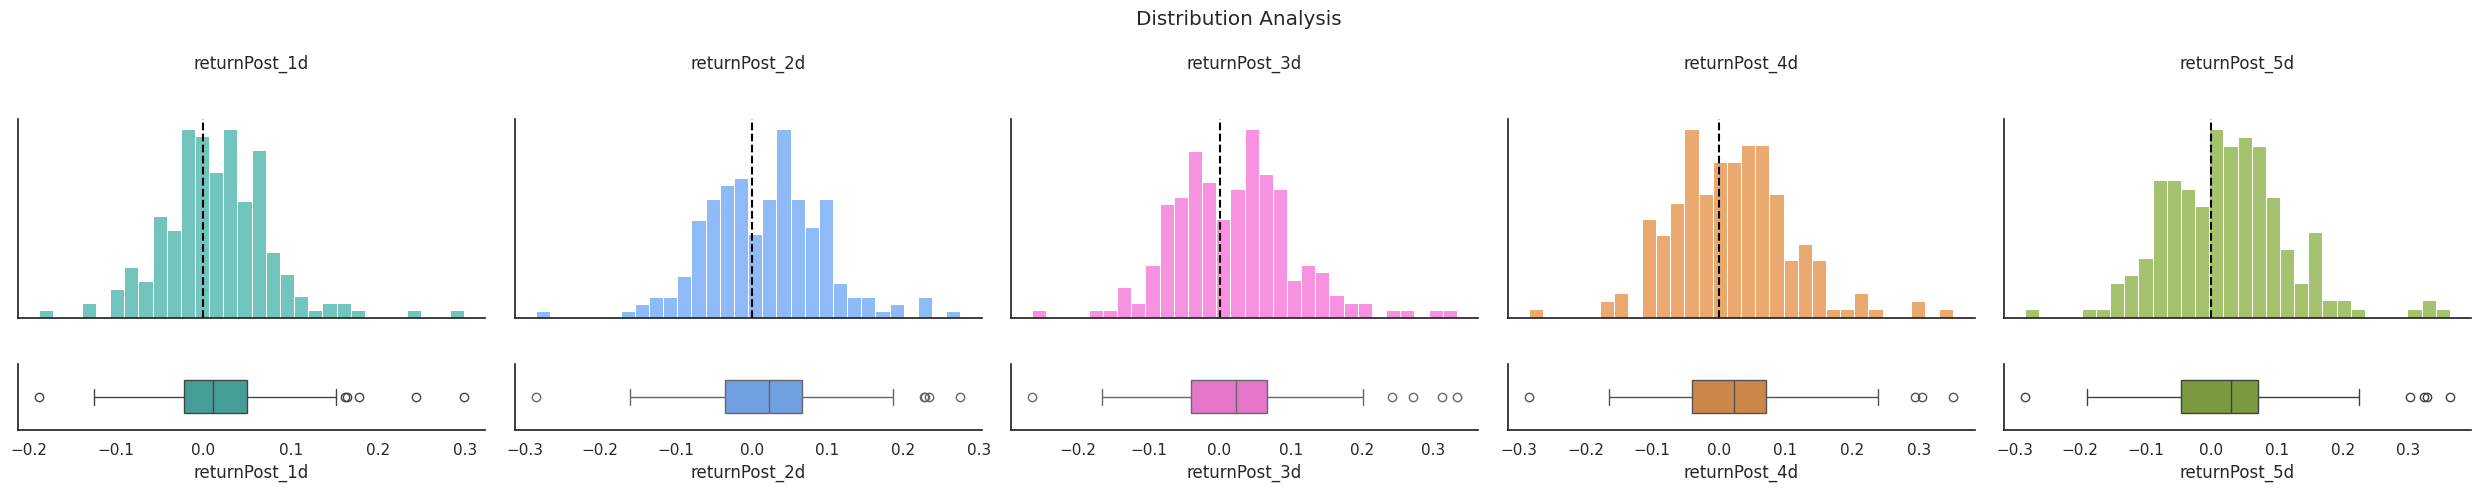

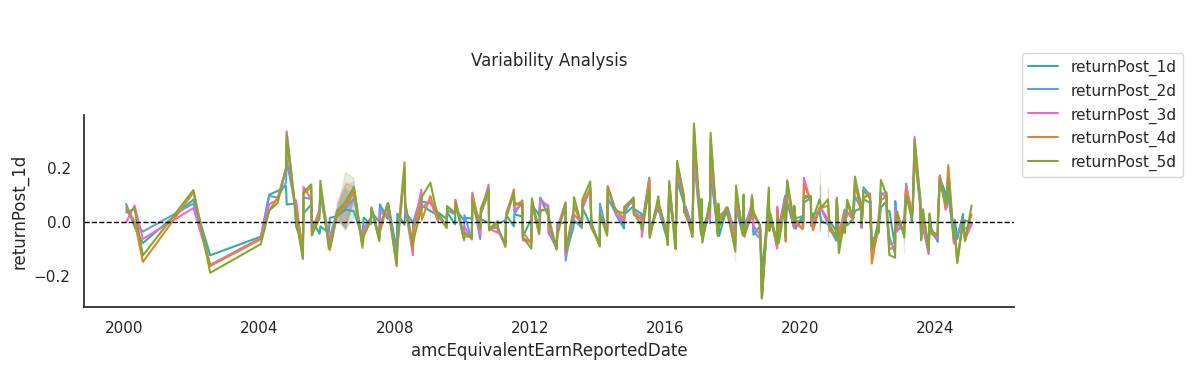

None

count  mean  std   min   25%  50%  75%  max  Range  IQR  \
returnPost_1d 207.00  0.01 0.06 -0.19 -0.02 0.01 0.05 0.30   0.49 0.07   
returnPost_2d 207.00  0.02 0.08 -0.29 -0.04 0.02 0.07 0.28   0.56 0.10   
returnPost_3d 207.00  0.02 0.08 -0.26 -0.04 0.02 0.07 0.33   0.60 0.11   
returnPost_4d 207.00  0.02 0.09 -0.28 -0.04 0.02 0.07 0.35   0.64 0.11   
returnPost_5d 207.00  0.02 0.09 -0.28 -0.05 0.03 0.07 0.36   0.65 0.12   

               Skewness (n=0)  Kurtosis (n=3)  Shapiro-Wilk, stat (n=1)  \
returnPost_1d            0.63            5.74                      0.96   
returnPost_2d            0.10            4.20                      0.98   
returnPost_3d            0.46            4.37                      0.98   
returnPost_4d            0.41            4.40                      0.98   
returnPost_5d            0.45            4.33                      0.98   

               Shapiro-Wilk, p-value (>0.05)  Outliers (IQR)  \
returnPost_1d                           0.00               6   
returnPost_2d                           0.02               5   
returnPost_3d                           0.00               5   
returnPost_4d                           0.00               4   
returnPost_5d                           0.00               5   

               Outliers (Tukey)  Outliers (Three-Sigma)  
returnPost_1d                 1                       3  
returnPost_2d                 0                       2  
returnPost_3d                 0                       3  
returnPost_4d                 0                       4  
returnPost_5d                 0                       5

In [33]:
# analyse distribution
display(plot_variable_distribution(df_eda, ['returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d',
       'returnPost_5d'], 'amcEquivalentEarnReportedDate'))
display(desc_stat_summary(df_eda).loc[['returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d',
       'returnPost_5d']])

**Note:**

- Distribution: leptokurtic right-skewed
- Outliers identified

**Approach:**
- Test 1d and 5d returns
- Apply Winsorisation to handle outliers
- log(1 + y) transformation, recognising positive skew & negative values


#### 5-day Return

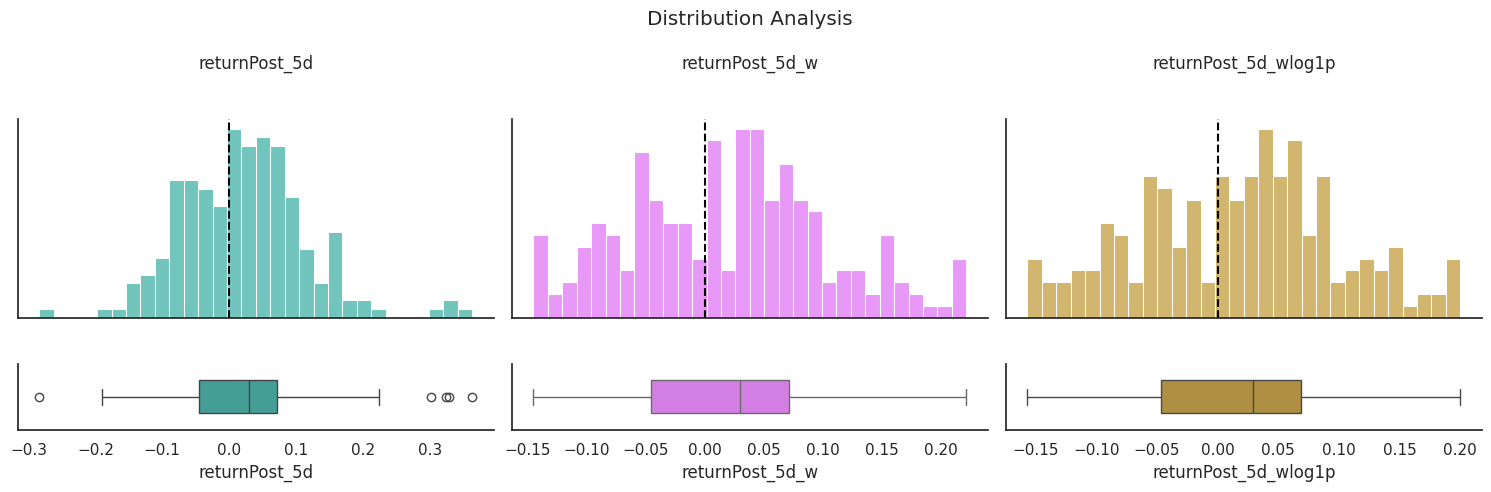

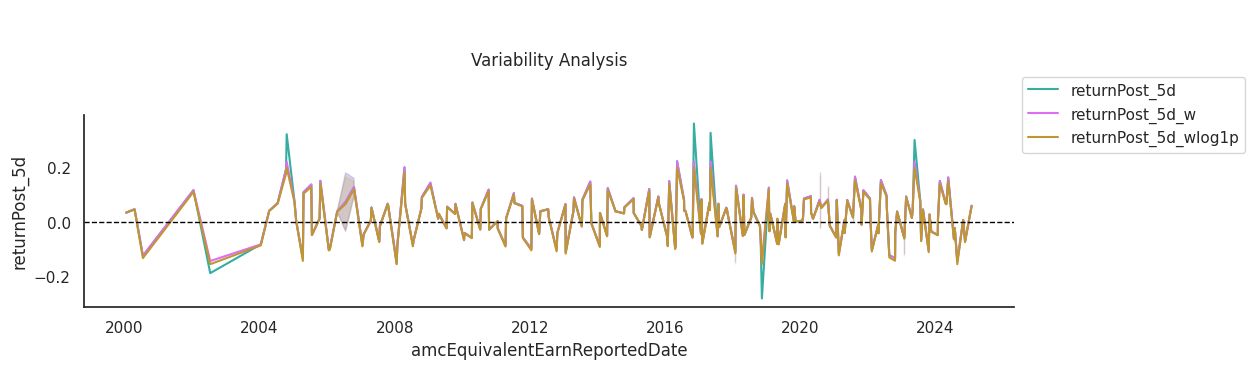

None

count  mean  std   min   25%  50%  75%  max  Range  IQR  \
returnPost_5d        207.00  0.02 0.09 -0.28 -0.05 0.03 0.07 0.36   0.65 0.12   
returnPost_5d_w      207.00  0.02 0.09 -0.15 -0.05 0.03 0.07 0.22   0.37 0.12   
returnPost_5d_wlog1p 207.00  0.02 0.08 -0.16 -0.05 0.03 0.07 0.20   0.36 0.12   

                      Skewness (n=0)  Kurtosis (n=3)  \
returnPost_5d                   0.45            4.33   
returnPost_5d_w                 0.18            2.58   
returnPost_5d_wlog1p           -0.01            2.49   

                      Shapiro-Wilk, stat (n=1)  Shapiro-Wilk, p-value (>0.05)  \
returnPost_5d                             0.98                           0.00   
returnPost_5d_w                           0.99                           0.04   
returnPost_5d_wlog1p                      0.99                           0.07   

                      Outliers (IQR)  Outliers (Tukey)  Outliers (Three-Sigma)  
returnPost_5d                      5                 0                       5  
returnPost_5d_w                    0                 0                       0  
returnPost_5d_wlog1p               0                 0                       0

In [34]:
# Winsorisation
# define caps (percentiles)
low, high = np.percentile(df_eda['returnPost_5d'], [2, 98])
# clip outliers
df_eda['returnPost_5d_w'] = np.clip(df_eda['returnPost_5d'], low, high)

# Apply Winsorisation & ln(1 + y) transformation
df_eda['returnPost_5d_wlog1p'] = np.log1p(df_eda['returnPost_5d_w'])

# evaluate options
list_of_variables = ['returnPost_5d', 'returnPost_5d_w', 'returnPost_5d_wlog1p']
display(plot_variable_distribution(df_eda, list_of_variables, 'amcEquivalentEarnReportedDate'))
display(desc_stat_summary(df_eda).loc[list_of_variables])

# export to csv
#df_eda.to_csv('returnPost_5d_wlog2.csv')

**Decision:**

The Winsorised Returns approach is chosen for further analysis as it maintains simplicity of the model and is comparable in terms of the range and distribution characteristics with log return.

**Rationale:**

Although the log(1 + y) transformation yields a higher Shapiro-Wilk p-value, the Winsorised returns approach on its own proves sufficient for this dataset:
- Winsorisation (at the 2nd and 98th percentiles) effectively normalises the distribution (Shapiro-Wilk p-value > 0.5) and removes outliers.
- The log(1 + y) transformation applied to winsorised returns marginally improves normality compared to Winsorisation. The introduction of log transformation will increase computational complexity, lead to loss of original data scale and as such interpretability and may distort the relationships.


In [35]:
# update earnings_df
#earnings_df = pd.merge(earnings_df, df_eda['1wkPost_Return_pct_w'], left_index=True, right_index=True)
#earnings_df.to_csv('earnings_df_YP.csv',index=False)

### EDA on Independent variables (X)

In [36]:
df_eda = earnings_data.copy()

In [37]:
desc_stat_summary(df_eda)

count           mean            std             min  \
netProfitMargin       207.00           0.23           0.09           -0.09   
netProfitMargin_ttm_y 203.00           0.23           0.08           -0.01   
epsEst                207.00           0.43           0.49            0.00   
epsAct                207.00           0.47           0.53            0.00   
epsSurpriseAbs        207.00           0.04           0.08           -0.19   
epsSurprise_pct       207.00           0.11           0.16           -0.17   
standEpsSurpriseScore 195.00           1.41           2.13           -3.35   
epsSurpriseChange_QoQ 203.00          -0.00           0.16           -0.52   
epsAct_YoY            200.00           0.60           1.53          -11.07   
revenueEst            204.00 30312439431.74 31281846739.79    604500000.00   
revenueAct            207.00 30968798492.75 31645420040.20    700212000.00   
revSurpriseAbs        204.00  1064532568.26  4888314140.67 -36325517621.00   
revSurprise_pct       204.00           0.07           0.14           -0.53   
standRevSurpriseScore 187.00           0.79           1.95          -12.65   
revSurpriseChange_QoQ 195.00          -0.01           0.20           -0.96   
revenueAct_YoY        200.00           0.32           0.39           -0.31   
returnPre_5d          207.00           0.01           0.04           -0.13   
returnPre_15d         206.00           0.03           0.08           -0.22   
returnPre_10d         207.00           0.01           0.06           -0.18   
closeCV_5d            207.00           0.02           0.01            0.00   
closeCV_15d           206.00           0.03           0.02            0.01   
closeCV_10d           207.00           0.02           0.01            0.00   
BOP_SMA_5d            207.00           0.03           0.22           -0.53   
BOP_SMA_15d           206.00           0.03           0.13           -0.38   
BOP_SMA_10d           207.00           0.02           0.15           -0.38   
returnPost_1d         207.00           0.01           0.06           -0.19   
returnPost_2d         207.00           0.02           0.08           -0.29   
returnPost_3d         207.00           0.02           0.08           -0.26   
returnPost_4d         207.00           0.02           0.09           -0.28   
returnPost_5d         207.00           0.02           0.09           -0.28   

                                25%            50%            75%  \
netProfitMargin                0.19           0.23           0.27   
netProfitMargin_ttm_y          0.21           0.22           0.26   
epsEst                         0.05           0.26           0.56   
epsAct                         0.06           0.27           0.63   
epsSurpriseAbs                 0.00           0.01           0.04   
epsSurprise_pct                0.02           0.08           0.18   
standEpsSurpriseScore          0.21           1.13           2.16   
epsSurpriseChange_QoQ         -0.07          -0.00           0.07   
epsAct_YoY                     0.08           0.26           0.70   
revenueEst            5234846888.25 16969084913.00 49997717207.00   
revenueAct            5225021500.00 16858000000.00 52737500000.00   
revSurpriseAbs          66000000.00   519830627.50  1859925000.00   
revSurprise_pct                0.01           0.05           0.13   
standRevSurpriseScore          0.03           0.59           1.54   
revSurpriseChange_QoQ         -0.07          -0.00           0.05   
revenueAct_YoY                 0.08           0.23           0.42   
returnPre_5d                  -0.01           0.01           0.03   
returnPre_15d                 -0.01           0.03           0.07   
returnPre_10d                 -0.02           0.02           0.05   
closeCV_5d                     0.01           0.02           0.02   
closeCV_15d                    0.02           0.02           0.04   
closeCV_10d                    0.01           0.02           0.03   
BOP_SMA_5d       

In [38]:
earnings_data[earnings_data['epsSurprise_pct'] == earnings_data['epsSurprise_pct'].max()]

symbol amcEquivalentEarnReportedDate earnReportedDate earnReportedTime  \
28   AAPL                    2009-10-19       2009-10-19              amc   

   fiscalDateEnding_ea weekday    month  netProfitMargin  \
28          2009-09-26  Monday  October             0.17   

    netProfitMargin_ttm_y  epsEst  ...  closeCV_15d  closeCV_10d  BOP_SMA_5d  \
28                   0.16    0.05  ...         0.02         0.00       -0.05   

    BOP_SMA_15d  BOP_SMA_10d  returnPost_1d  returnPost_2d  returnPost_3d  \
28         0.01         0.10           0.05           0.08           0.08   

    returnPost_4d  returnPost_5d  
28           0.07           0.07  

[1 rows x 37 columns]

In [39]:
# Identify the row with the maximum epsSurprise_pct and drop it
earnings_data = earnings_data.drop(earnings_data[earnings_data['epsSurprise_pct'] == earnings_data['epsSurprise_pct'].max()].index)
desc_stat_summary(earnings_data)

count           mean            std             min  \
netProfitMargin       206.00           0.23           0.09           -0.09   
netProfitMargin_ttm_y 202.00           0.23           0.08           -0.01   
epsEst                206.00           0.43           0.50            0.00   
epsAct                206.00           0.47           0.53            0.00   
epsSurpriseAbs        206.00           0.04           0.08           -0.19   
epsSurprise_pct       206.00           0.11           0.15           -0.17   
standEpsSurpriseScore 194.00           1.33           1.78           -3.35   
epsSurpriseChange_QoQ 202.00          -0.01           0.14           -0.52   
epsAct_YoY            199.00           0.60           1.53          -11.07   
revenueEst            203.00 30415505635.84 31324439579.87    604500000.00   
revenueAct            206.00 31071219844.66 31688098658.10    700212000.00   
revSurpriseAbs        203.00  1067412039.04  4900225551.24 -36325517621.00   
revSurprise_pct       203.00           0.07           0.14           -0.53   
standRevSurpriseScore 186.00           0.80           1.95          -12.65   
revSurpriseChange_QoQ 194.00          -0.01           0.20           -0.96   
revenueAct_YoY        199.00           0.32           0.39           -0.31   
returnPre_5d          206.00           0.01           0.04           -0.13   
returnPre_15d         205.00           0.03           0.08           -0.22   
returnPre_10d         206.00           0.01           0.06           -0.18   
closeCV_5d            206.00           0.02           0.01            0.00   
closeCV_15d           205.00           0.03           0.02            0.01   
closeCV_10d           206.00           0.02           0.01            0.00   
BOP_SMA_5d            206.00           0.03           0.22           -0.53   
BOP_SMA_15d           205.00           0.03           0.13           -0.38   
BOP_SMA_10d           206.00           0.02           0.15           -0.38   
returnPost_1d         206.00           0.01           0.06           -0.19   
returnPost_2d         206.00           0.02           0.08           -0.29   
returnPost_3d         206.00           0.02           0.08           -0.26   
returnPost_4d         206.00           0.02           0.09           -0.28   
returnPost_5d         206.00           0.02           0.09           -0.28   

                                25%            50%            75%  \
netProfitMargin                0.19           0.23           0.27   
netProfitMargin_ttm_y          0.21           0.22           0.26   
epsEst                         0.05           0.27           0.56   
epsAct                         0.05           0.27           0.64   
epsSurpriseAbs                 0.00           0.01           0.04   
epsSurprise_pct                0.02           0.08           0.17   
standEpsSurpriseScore          0.21           1.13           2.11   
epsSurpriseChange_QoQ         -0.07          -0.00           0.07   
epsAct_YoY                     0.08           0.26           0.68   
revenueEst            5229425484.50 16978457886.00 50292116233.00   
revenueAct            5205532250.00 17058000000.00 52816750000.00   
revSurpriseAbs          66000000.00   526345465.00  1861350000.00   
revSurprise_pct                0.01           0.05           0.13   
standRevSurpriseScore          0.02           0.60           1.54   
revSurpriseChange_QoQ         -0.07          -0.00           0.05   
revenueAct_YoY                 0.08           0.23           0.42   
returnPre_5d                  -0.01           0.01           0.03   
returnPre_15d                 -0.01           0.03           0.07   
returnPre_10d                 -0.02           0.02           0.05   
closeCV_5d                     0.01           0.02           0.02   
closeCV_15d                    0.02           0.02           0.04   
closeCV_10d                    0.01           0.02           0.03   
BOP_SMA_5d       

In [40]:
# Identify the row with the maximum epsSurprise_pct and drop it
earnings_data = earnings_data[earnings_data['netProfitMargin'] >= 0.05]

<Axes: xlabel='returnPost_2d', ylabel='epsSurprise_pct'>

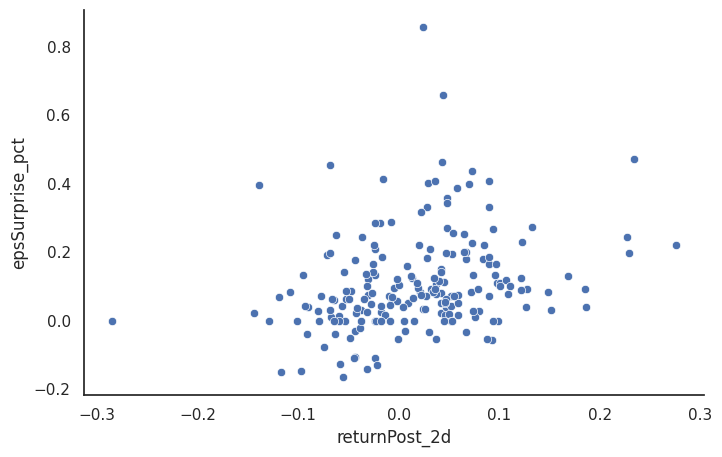

In [41]:
# Create scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=earnings_data, x='returnPost_2d', y='epsSurprise_pct')

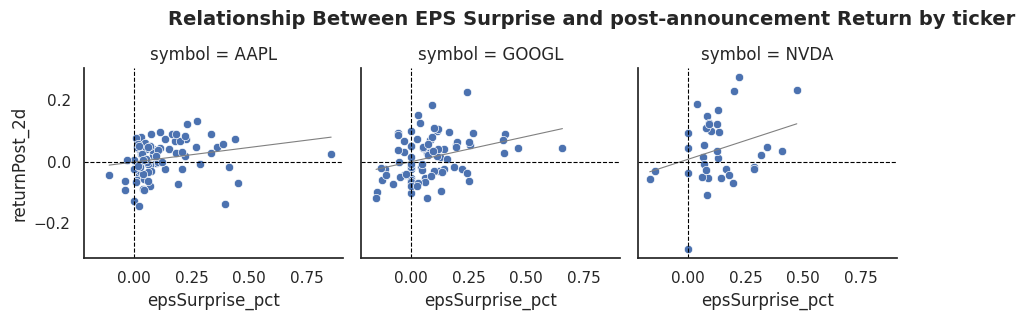

In [42]:
# Create Faceted Scatter Plot
g = sns.FacetGrid(earnings_data, col='symbol', col_wrap=4, height=3, aspect=1, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x='epsSurprise_pct', y='returnPost_2d')
g.map_dataframe(sns.regplot, x='epsSurprise_pct', y='returnPost_2d', scatter=False, ci=None, color='grey', line_kws={'linestyle': '-', 'linewidth': 0.8})

# Add horizontal and vertical lines at y=0 and x=0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Set Super Title
g.fig.suptitle('Relationship Between EPS Surprise and post-announcement Return by ticker', fontsize=14, fontweight='bold', y=1.06, ha='center')

# Show plot
plt.show()

In [43]:
earnings_data.columns

Index(['symbol', 'amcEquivalentEarnReportedDate', 'earnReportedDate',
       'earnReportedTime', 'fiscalDateEnding_ea', 'weekday', 'month',
       'netProfitMargin', 'netProfitMargin_ttm_y', 'epsEst', 'epsAct',
       'epsSurpriseAbs', 'epsSurprise_pct', 'standEpsSurpriseScore',
       'epsSurpriseChange_QoQ', 'epsAct_YoY', 'revenueEst', 'revenueAct',
       'revSurpriseAbs', 'revSurprise_pct', 'standRevSurpriseScore',
       'revSurpriseChange_QoQ', 'revenueAct_YoY', 'returnPre_5d',
       'returnPre_15d', 'returnPre_10d', 'closeCV_5d', 'closeCV_15d',
       'closeCV_10d', 'BOP_SMA_5d', 'BOP_SMA_15d', 'BOP_SMA_10d',
       'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d',
       'returnPost_5d'],
      dtype='object')

In [44]:
corr_df = earnings_data[['symbol', 'amcEquivalentEarnReportedDate', 'earnReportedDate',
       'earnReportedTime', 'fiscalDateEnding_ea', 'weekday', 'month',
       'epsSurprise_pct', 'standEpsSurpriseScore',
       'epsSurpriseChange_QoQ', 'epsAct_YoY', 'revSurprise_pct', 'standRevSurpriseScore',
       'revSurpriseChange_QoQ', 'revenueAct_YoY', 'returnPre_5d',
       'returnPre_15d', 'returnPre_10d', 'closeCV_5d', 'closeCV_15d',
       'closeCV_10d', 'BOP_SMA_5d', 'BOP_SMA_15d', 'BOP_SMA_10d',
       'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d',
       'returnPost_5d']].copy()

In [45]:
#Sujith Changes - Columns renamed for correlation chart below for the Final presentation
corr_df.rename(columns={'epsSurprise_pct':'EPS_Surprise_%','standEpsSurpriseScore':'Surprise_Score','epsAct_YoY':'EPS_Actual_YoY','revSurprise_pct':'rev_Surprise_%',
                        'revenueAct_YoY':'ActualRevenue_YoY','closeCV_5d':'5Day_Price_Volatility', 'closeCV_15d':'15-Day_Price_Volatility','closeCV_10d':'10-Day_Price_Volatility',
                        'BOP_SMA_5d':'5-Day_MarketMomentum', 'BOP_SMA_15d':'15-Day_MarketMomentum', 'BOP_SMA_10d':'10-Day_MarketMomentum'},inplace=True)

In [46]:
corr_df.columns

Index(['symbol', 'amcEquivalentEarnReportedDate', 'earnReportedDate',
       'earnReportedTime', 'fiscalDateEnding_ea', 'weekday', 'month',
       'EPS_Surprise_%', 'Surprise_Score', 'epsSurpriseChange_QoQ',
       'EPS_Actual_YoY', 'rev_Surprise_%', 'standRevSurpriseScore',
       'revSurpriseChange_QoQ', 'ActualRevenue_YoY', 'returnPre_5d',
       'returnPre_15d', 'returnPre_10d', '5Day_Price_Volatility',
       '15-Day_Price_Volatility', '10-Day_Price_Volatility',
       '5-Day_MarketMomentum', '15-Day_MarketMomentum',
       '10-Day_MarketMomentum', 'returnPost_1d', 'returnPost_2d',
       'returnPost_3d', 'returnPost_4d', 'returnPost_5d'],
      dtype='object')

In [47]:
return_windows = ['returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d']

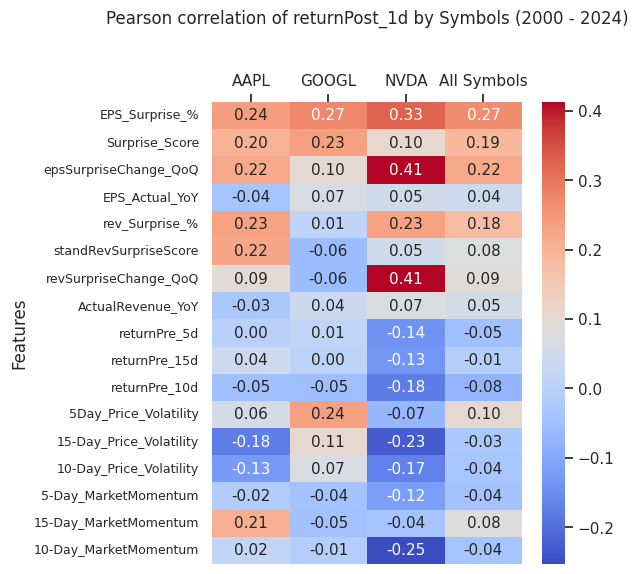

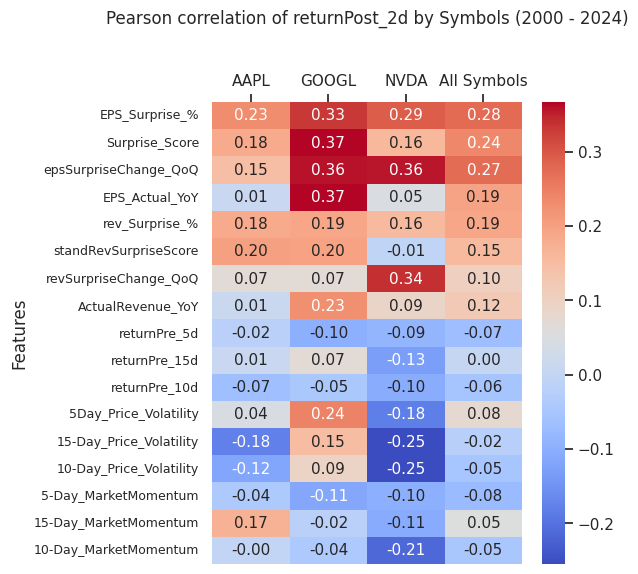

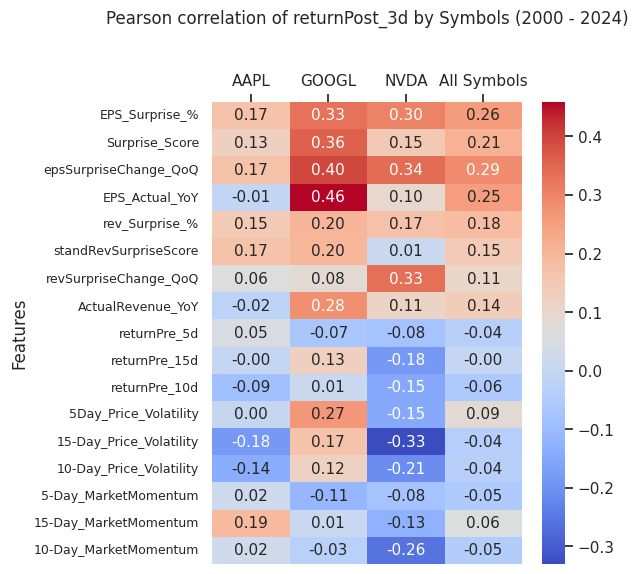

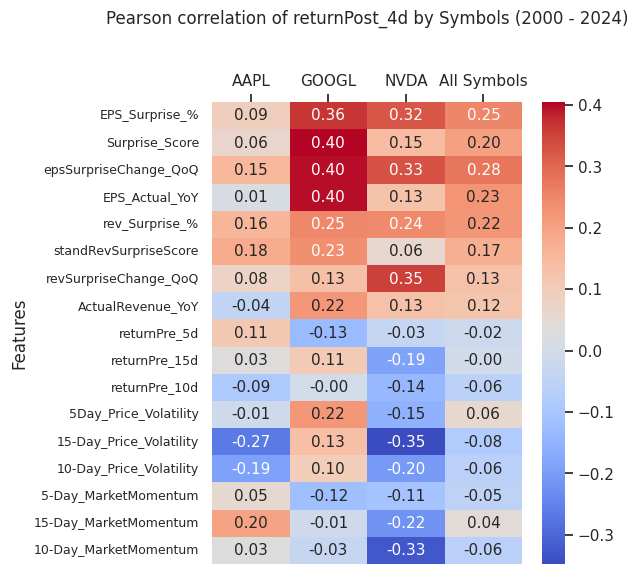

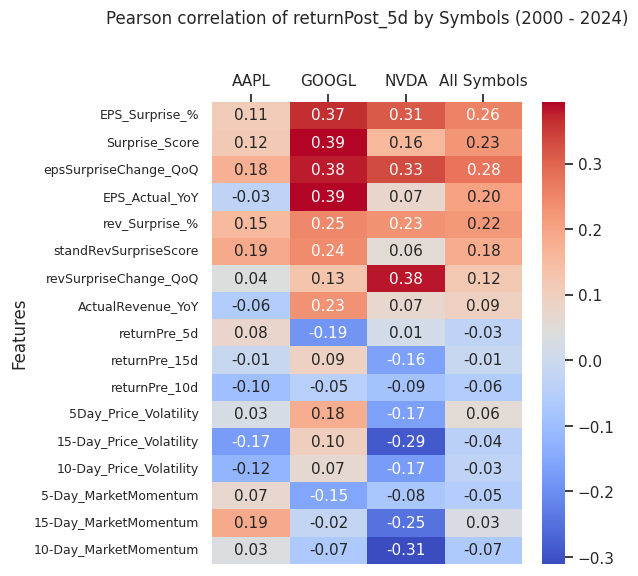

In [48]:
#correlation_analysis(mlr_df, '1wkPost_Return_pct', 'ticker', 'all records', method='pearson', export=True)

for window in return_windows:
    columns_to_drop = [col for col in return_windows if col not in window]
    correlation_analysis(
        df=corr_df.drop(columns=columns_to_drop),
        target_variable=window, category='symbol',
        sample_desc='2000 - 2024',
        method='pearson',
        export=True)

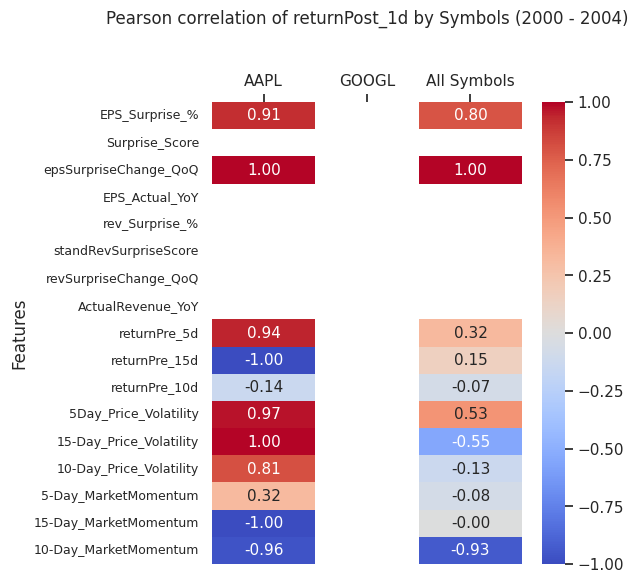

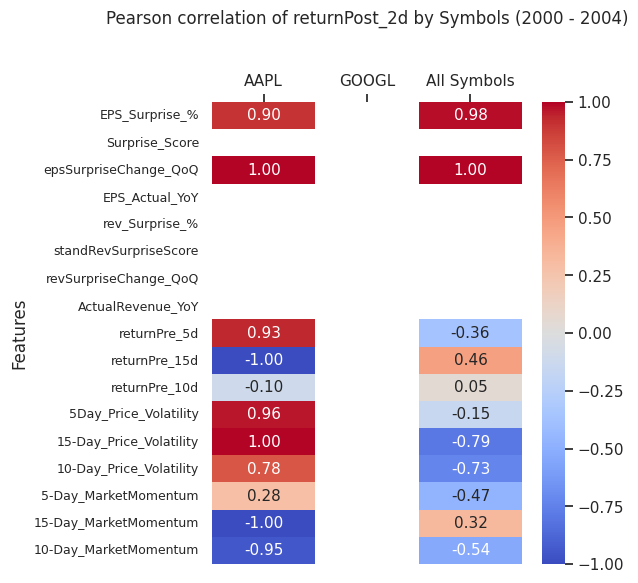

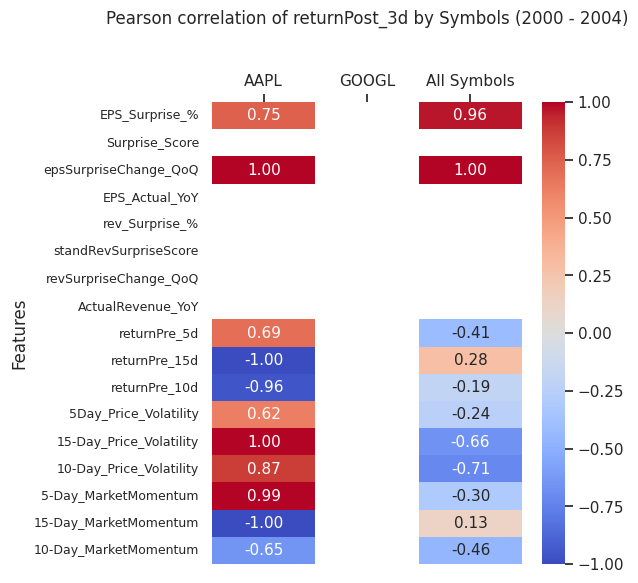

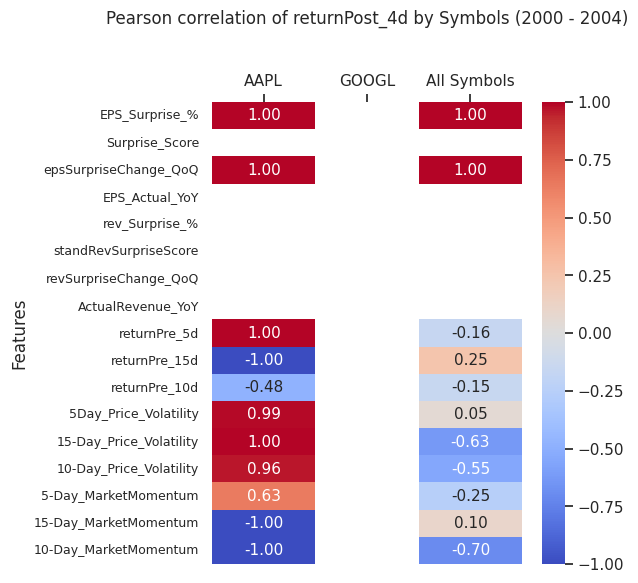

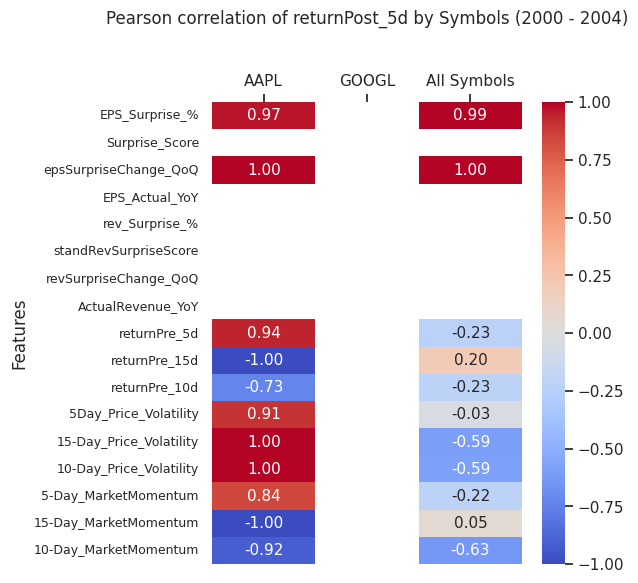

In [49]:
# correlation of post-announcement return and features 2000 - 2004 by symbol and post-announcement window

for window in return_windows:
    filtered_df = corr_df[
    (corr_df['amcEquivalentEarnReportedDate'] >= '1999-12-31') &
    (corr_df['amcEquivalentEarnReportedDate'] <= '2004-12-31')
    ]
    columns_to_drop = [col for col in return_windows if col not in window]
    correlation_analysis(
        df=filtered_df.drop(columns=columns_to_drop),
        target_variable=window, category='symbol',
        sample_desc='2000 - 2004',
        method='pearson',
        export=True)

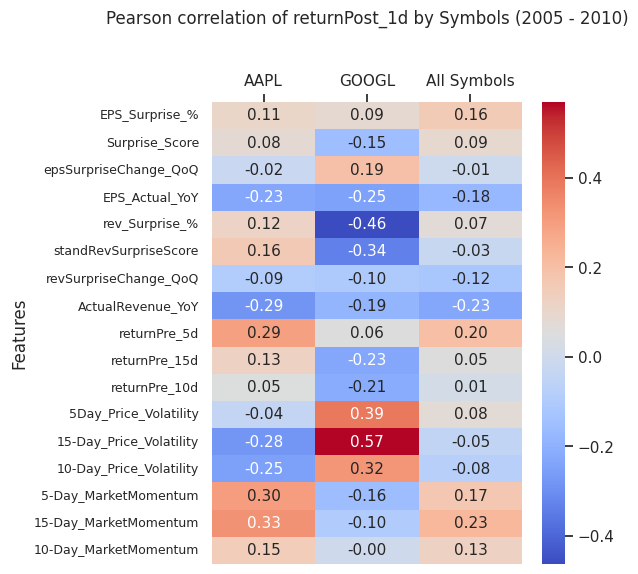

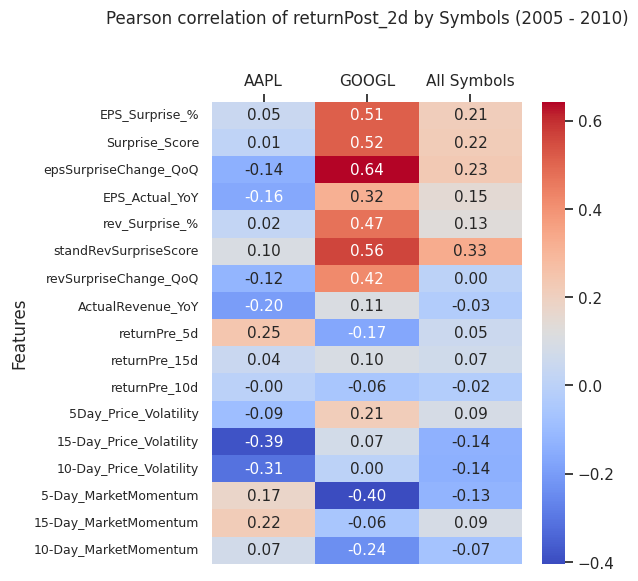

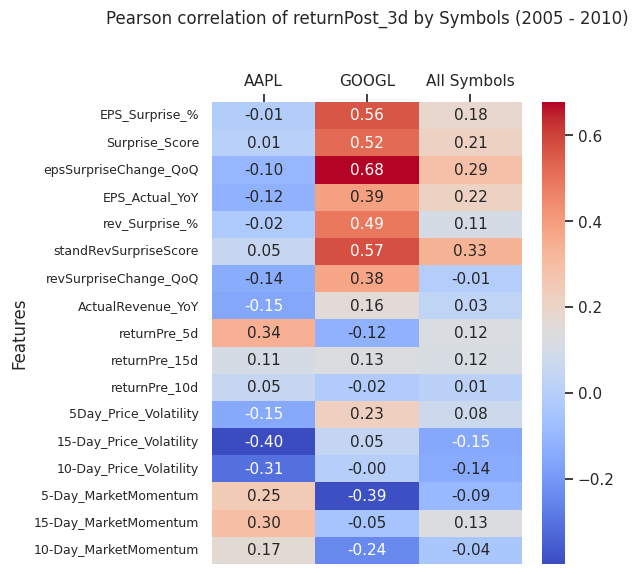

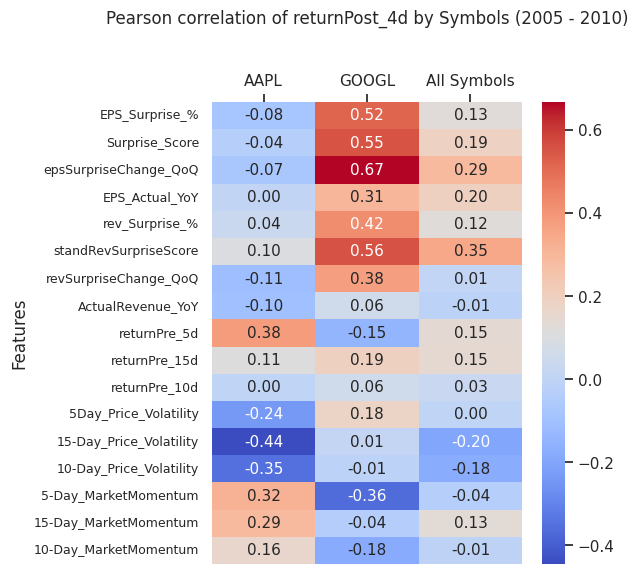

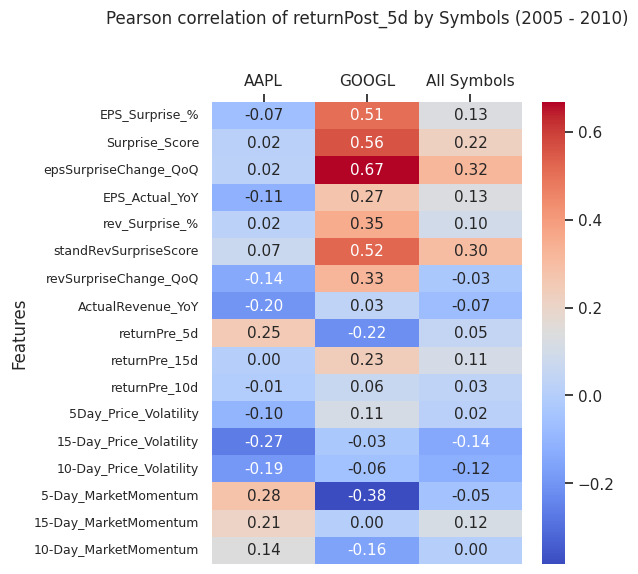

In [50]:
# correlation of post-announcement return and features 2005 - 2010 by symbol and post-announcement window

for window in return_windows:
    filtered_df = corr_df[
    (corr_df['amcEquivalentEarnReportedDate'] >= '2005-01-01') &
    (corr_df['amcEquivalentEarnReportedDate'] <= '2010-12-31')
    ]
    columns_to_drop = [col for col in return_windows if col not in window]
    correlation_analysis(
        df=filtered_df.drop(columns=columns_to_drop),
        target_variable=window, category='symbol',
        sample_desc='2005 - 2010',
        method='pearson',
        export=True)

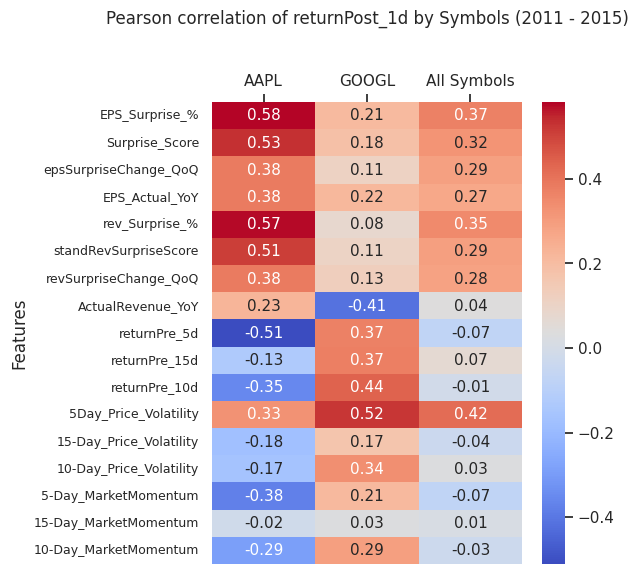

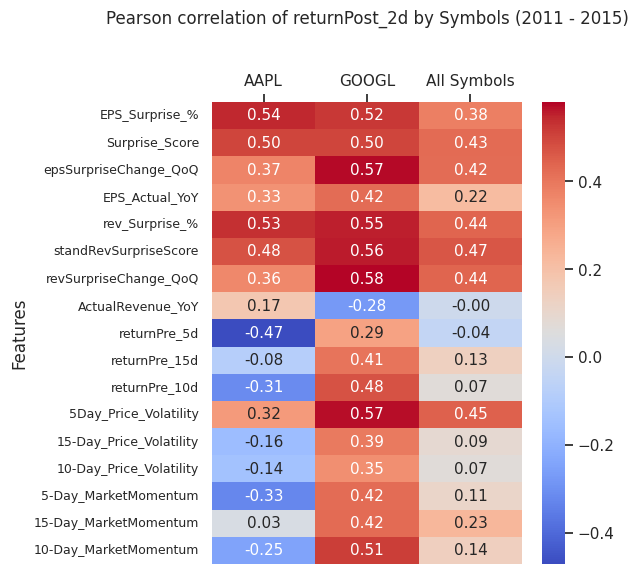

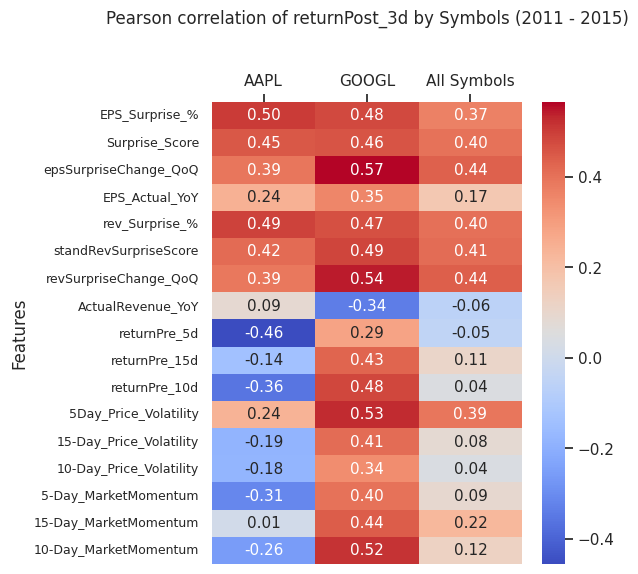

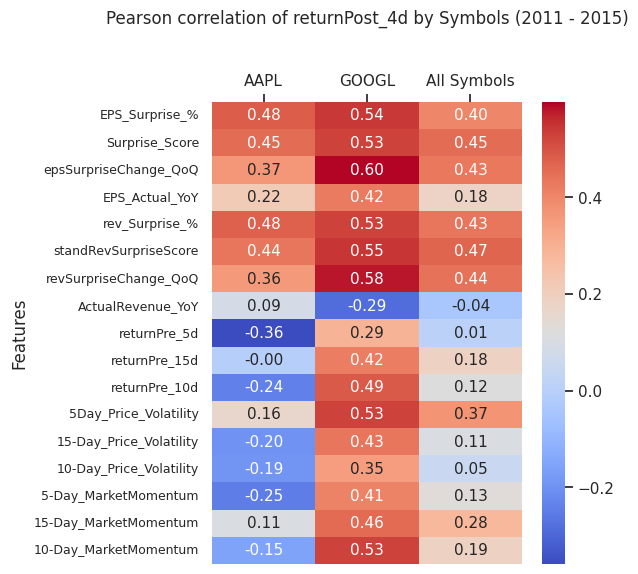

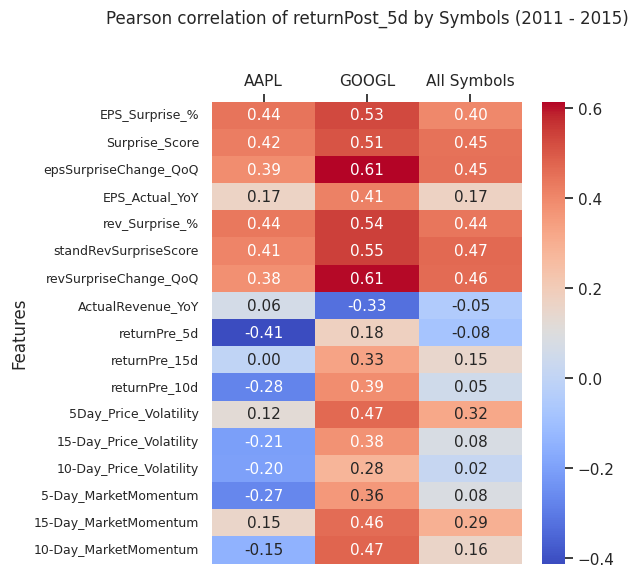

In [51]:
# correlation of post-announcement return and features 2011 - 2015 by symbol and post-announcement window

for window in return_windows:
    filtered_df = corr_df[
    (corr_df['amcEquivalentEarnReportedDate'] >= '2011-01-01') &
    (corr_df['amcEquivalentEarnReportedDate'] <= '2015-12-31')
    ]
    columns_to_drop = [col for col in return_windows if col not in window]
    correlation_analysis(
        df=filtered_df.drop(columns=columns_to_drop),
        target_variable=window, category='symbol',
        sample_desc='2011 - 2015',
        method='pearson',
        export=True)

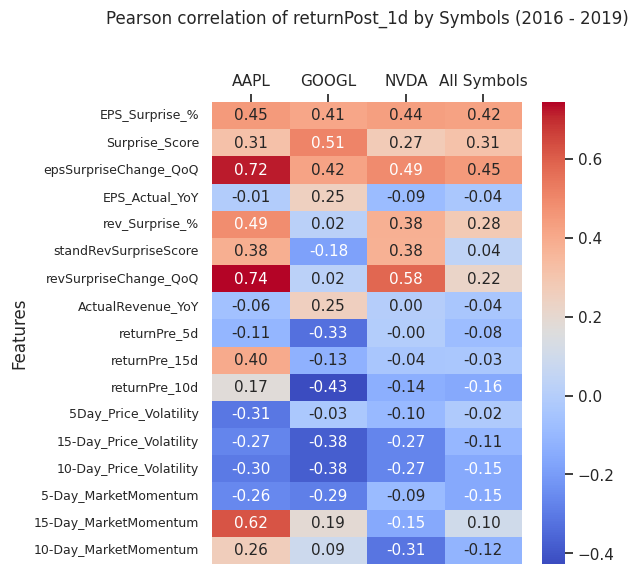

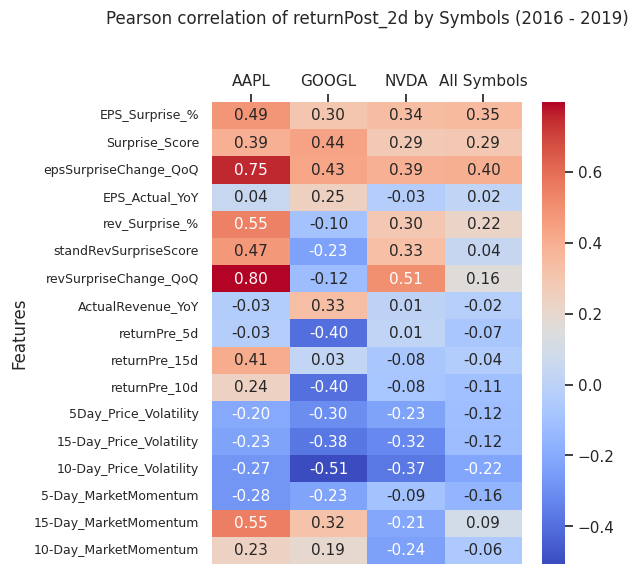

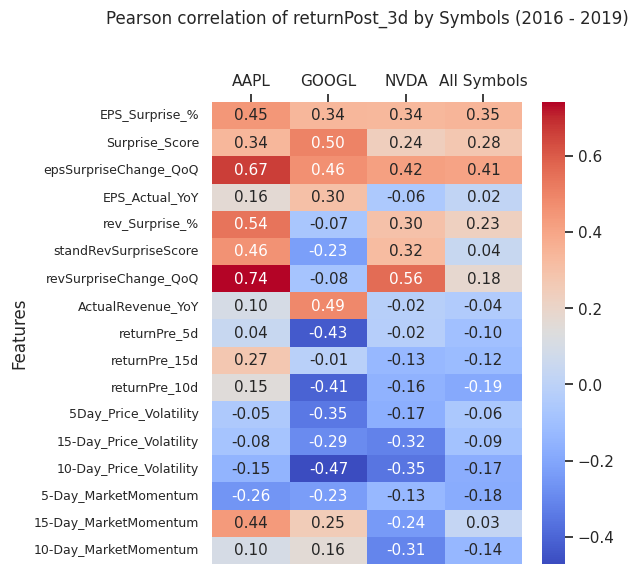

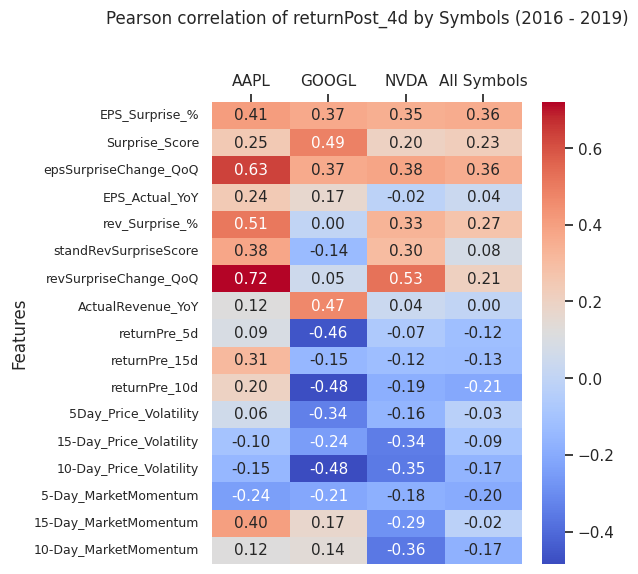

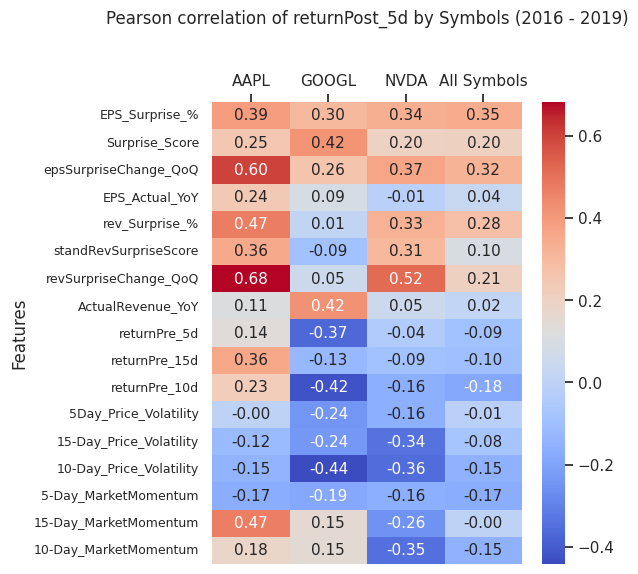

In [52]:
# correlation of post-announcement return and features 2016 - 2019 by symbol and post-announcement window

for window in return_windows:
    filtered_df = corr_df[
    (corr_df['amcEquivalentEarnReportedDate'] >= '2016-01-01') &
    (corr_df['amcEquivalentEarnReportedDate'] <= '2019-12-31')
    ]
    columns_to_drop = [col for col in return_windows if col not in window]
    correlation_analysis(
        df=filtered_df.drop(columns=columns_to_drop),
        target_variable=window, category='symbol',
        sample_desc='2016 - 2019',
        method='pearson',
        export=True)

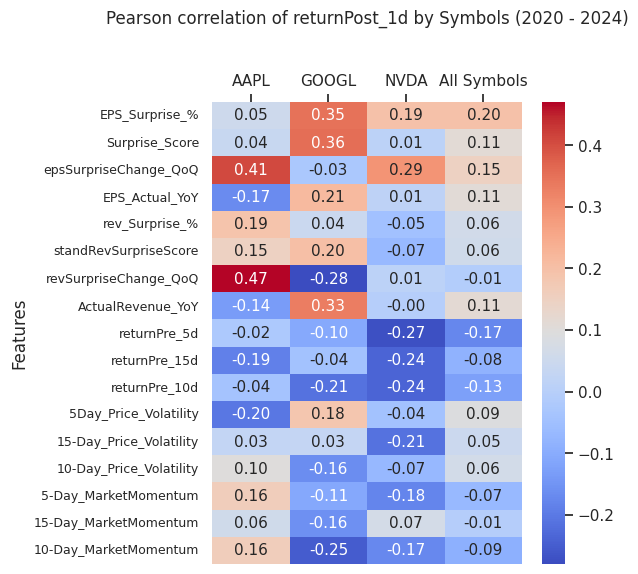

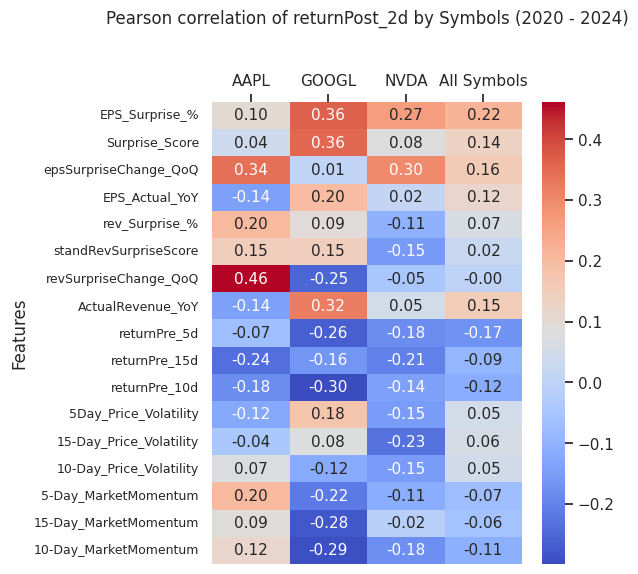

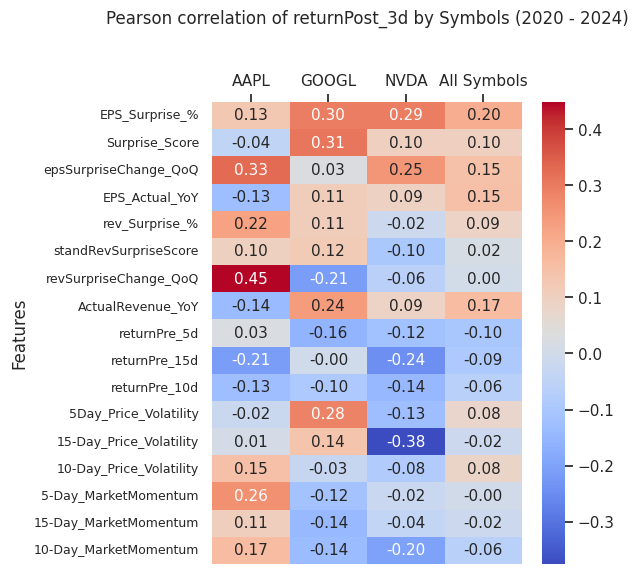

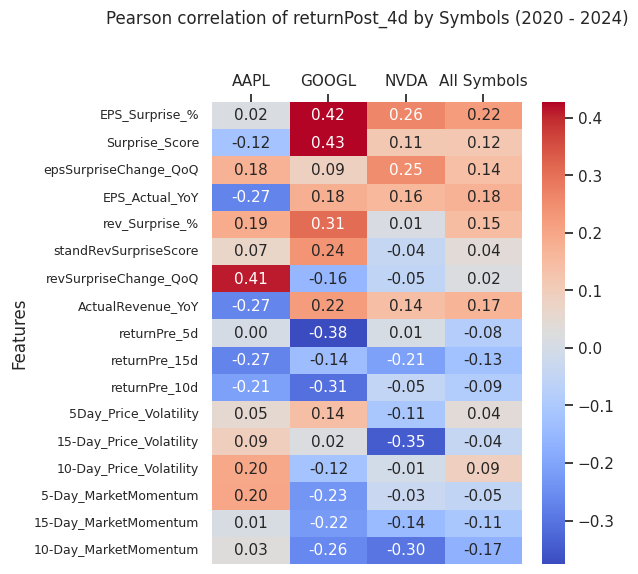

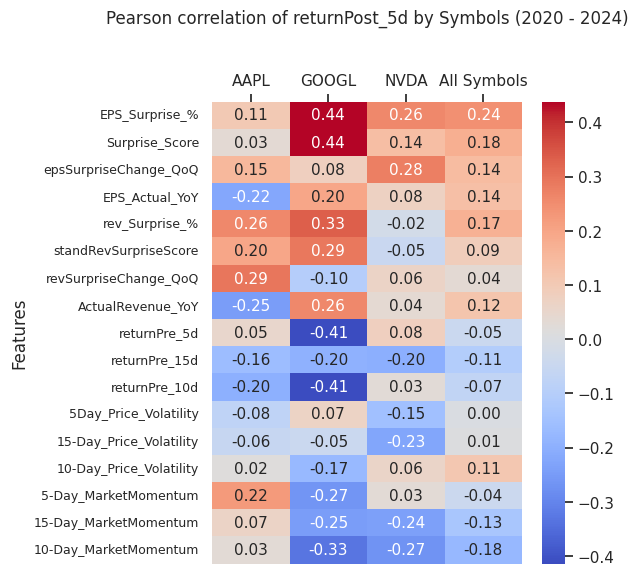

In [53]:
# Corelation of post-announcement return and features 2020 - 2024 by symbol and post-announcement window

for window in return_windows:
    filtered_df = corr_df[
    (corr_df['amcEquivalentEarnReportedDate'] >= '2020-01-01') &
    (corr_df['amcEquivalentEarnReportedDate'] <= '2024-12-31')
    ]
    columns_to_drop = [col for col in return_windows if col not in window]
    correlation_analysis(
        df=filtered_df.drop(columns=columns_to_drop),
        target_variable=window, category='symbol',
        sample_desc='2020 - 2024',
        method='pearson',
        export=True)

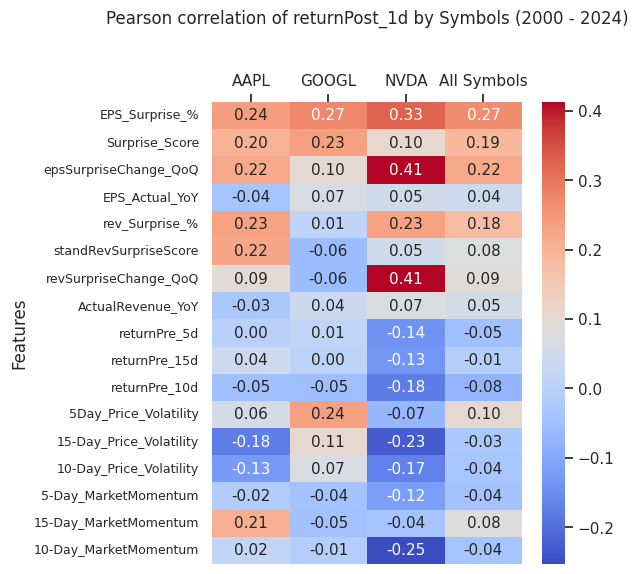

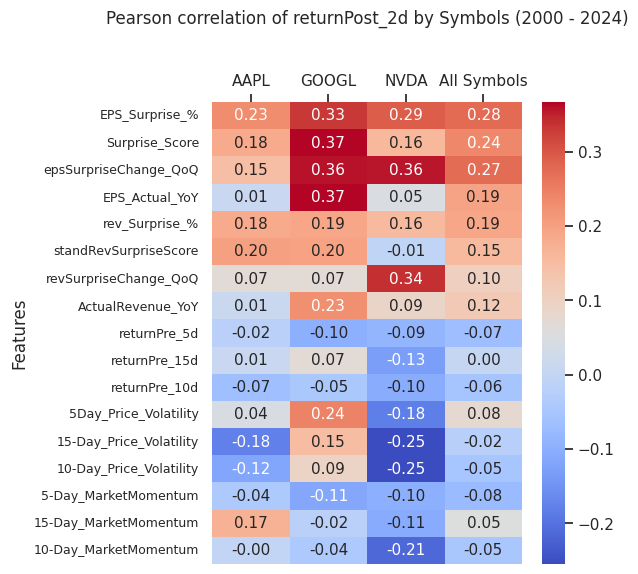

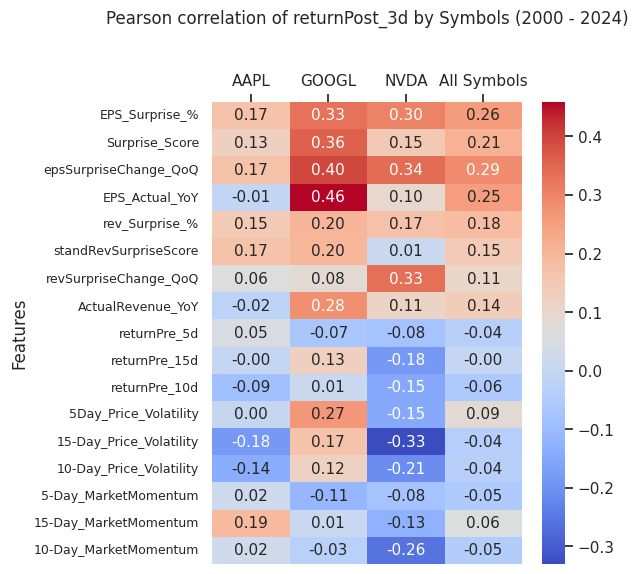

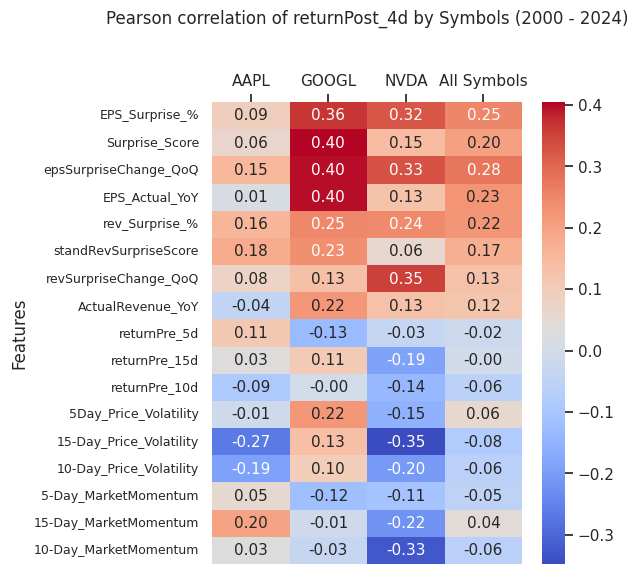

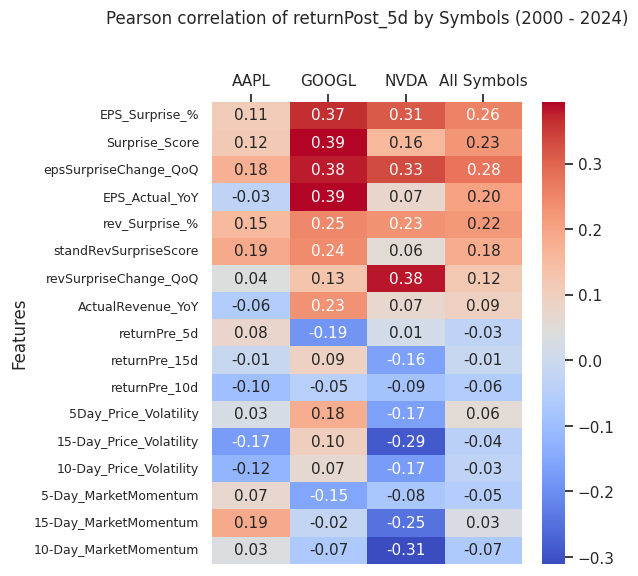

In [54]:
#correlation_analysis(mlr_df, '1wkPost_Return_pct', 'ticker', 'all records', method='pearson', export=True)

for window in return_windows:
    columns_to_drop = [col for col in return_windows if col not in window]
    correlation_analysis(
        df=corr_df.drop(columns=columns_to_drop),
        target_variable=window, category='symbol',
        sample_desc='2000 - 2024',
        method='pearson',
        export=True)

In [55]:
corr_df.columns

Index(['symbol', 'amcEquivalentEarnReportedDate', 'earnReportedDate',
       'earnReportedTime', 'fiscalDateEnding_ea', 'weekday', 'month',
       'EPS_Surprise_%', 'Surprise_Score', 'epsSurpriseChange_QoQ',
       'EPS_Actual_YoY', 'rev_Surprise_%', 'standRevSurpriseScore',
       'revSurpriseChange_QoQ', 'ActualRevenue_YoY', 'returnPre_5d',
       'returnPre_15d', 'returnPre_10d', '5Day_Price_Volatility',
       '15-Day_Price_Volatility', '10-Day_Price_Volatility',
       '5-Day_MarketMomentum', '15-Day_MarketMomentum',
       '10-Day_MarketMomentum', 'returnPost_1d', 'returnPost_2d',
       'returnPost_3d', 'returnPost_4d', 'returnPost_5d'],
      dtype='object')

In [56]:
# Add the 'surpriseDirection' column
corr_df['epsSurpriseDirection'] = corr_df['EPS_Surprise_%'].apply(lambda x: 'positive' if x >= 0 else 'negative')

In [57]:
corr_df.loc[
corr_df['amcEquivalentEarnReportedDate'] <= '2004-12-31',
'period'
] = '2000-2004'

corr_df.loc[
(corr_df['amcEquivalentEarnReportedDate'] >= '2005-01-01') &
(corr_df['amcEquivalentEarnReportedDate'] <= '2010-12-31'),
'period'
] = '2005-2010'

corr_df.loc[
(corr_df['amcEquivalentEarnReportedDate'] >= '2011-01-01') &
(corr_df['amcEquivalentEarnReportedDate'] <= '2015-12-31'),
'period'
] = '2011-2015'


corr_df.loc[
(corr_df['amcEquivalentEarnReportedDate'] >= '2016-01-01') &
(corr_df['amcEquivalentEarnReportedDate'] <= '2019-12-31'),
'period'
] = '2016-2019'

corr_df.loc[
corr_df['amcEquivalentEarnReportedDate'] >= '2020-01-01',
'period'
] = '2020-2024'

In [58]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 0 to 917
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   symbol                         199 non-null    string        
 1   amcEquivalentEarnReportedDate  199 non-null    datetime64[ns]
 2   earnReportedDate               199 non-null    datetime64[ns]
 3   earnReportedTime               199 non-null    string        
 4   fiscalDateEnding_ea            199 non-null    datetime64[ns]
 5   weekday                        199 non-null    string        
 6   month                          199 non-null    string        
 7   EPS_Surprise_%                 199 non-null    float64       
 8   Surprise_Score                 188 non-null    float64       
 9   epsSurpriseChange_QoQ          195 non-null    float64       
 10  EPS_Actual_YoY                 192 non-null    float64       
 11  rev_Surprise_%          

In [59]:
#windows_df = corr_df[['epsSurpriseDirection', 'symbol', 'returnPre_15d', 'returnPre_10d', 'returnPre_5d', 'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d']]

windows_df = corr_df[['epsSurpriseDirection', 'symbol', 'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d']]


windows_df.columns

Index(['epsSurpriseDirection', 'symbol', 'returnPost_1d', 'returnPost_2d',
       'returnPost_3d', 'returnPost_4d', 'returnPost_5d'],
      dtype='object')

In [60]:
windows_df = windows_df.melt(
    id_vars=['epsSurpriseDirection', 'symbol'],
#    value_vars=['returnPre_15d', 'returnPre_10d', 'returnPre_5d', 'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d'],
    value_vars=['returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d'],
    var_name='return_period',
    value_name='return_value'
)

post_list = ['returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d']

# Add the 'surpriseDirection' column
windows_df['windowType'] = windows_df['return_period'].apply(lambda x: 'post' if x in post_list else 'pre')

windows_df.columns

Index(['epsSurpriseDirection', 'symbol', 'return_period', 'return_value',
       'windowType'],
      dtype='object')

In [61]:
#order = ['returnPre_15d', 'returnPre_10d', 'returnPre_5d', 'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d']
order = ['returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d']

In [62]:
symbol_order = ['AAPL', 'GOOGL', 'NVDA']
dir_order = ['positive', 'negative']
wtype_order = ['pre', 'post']

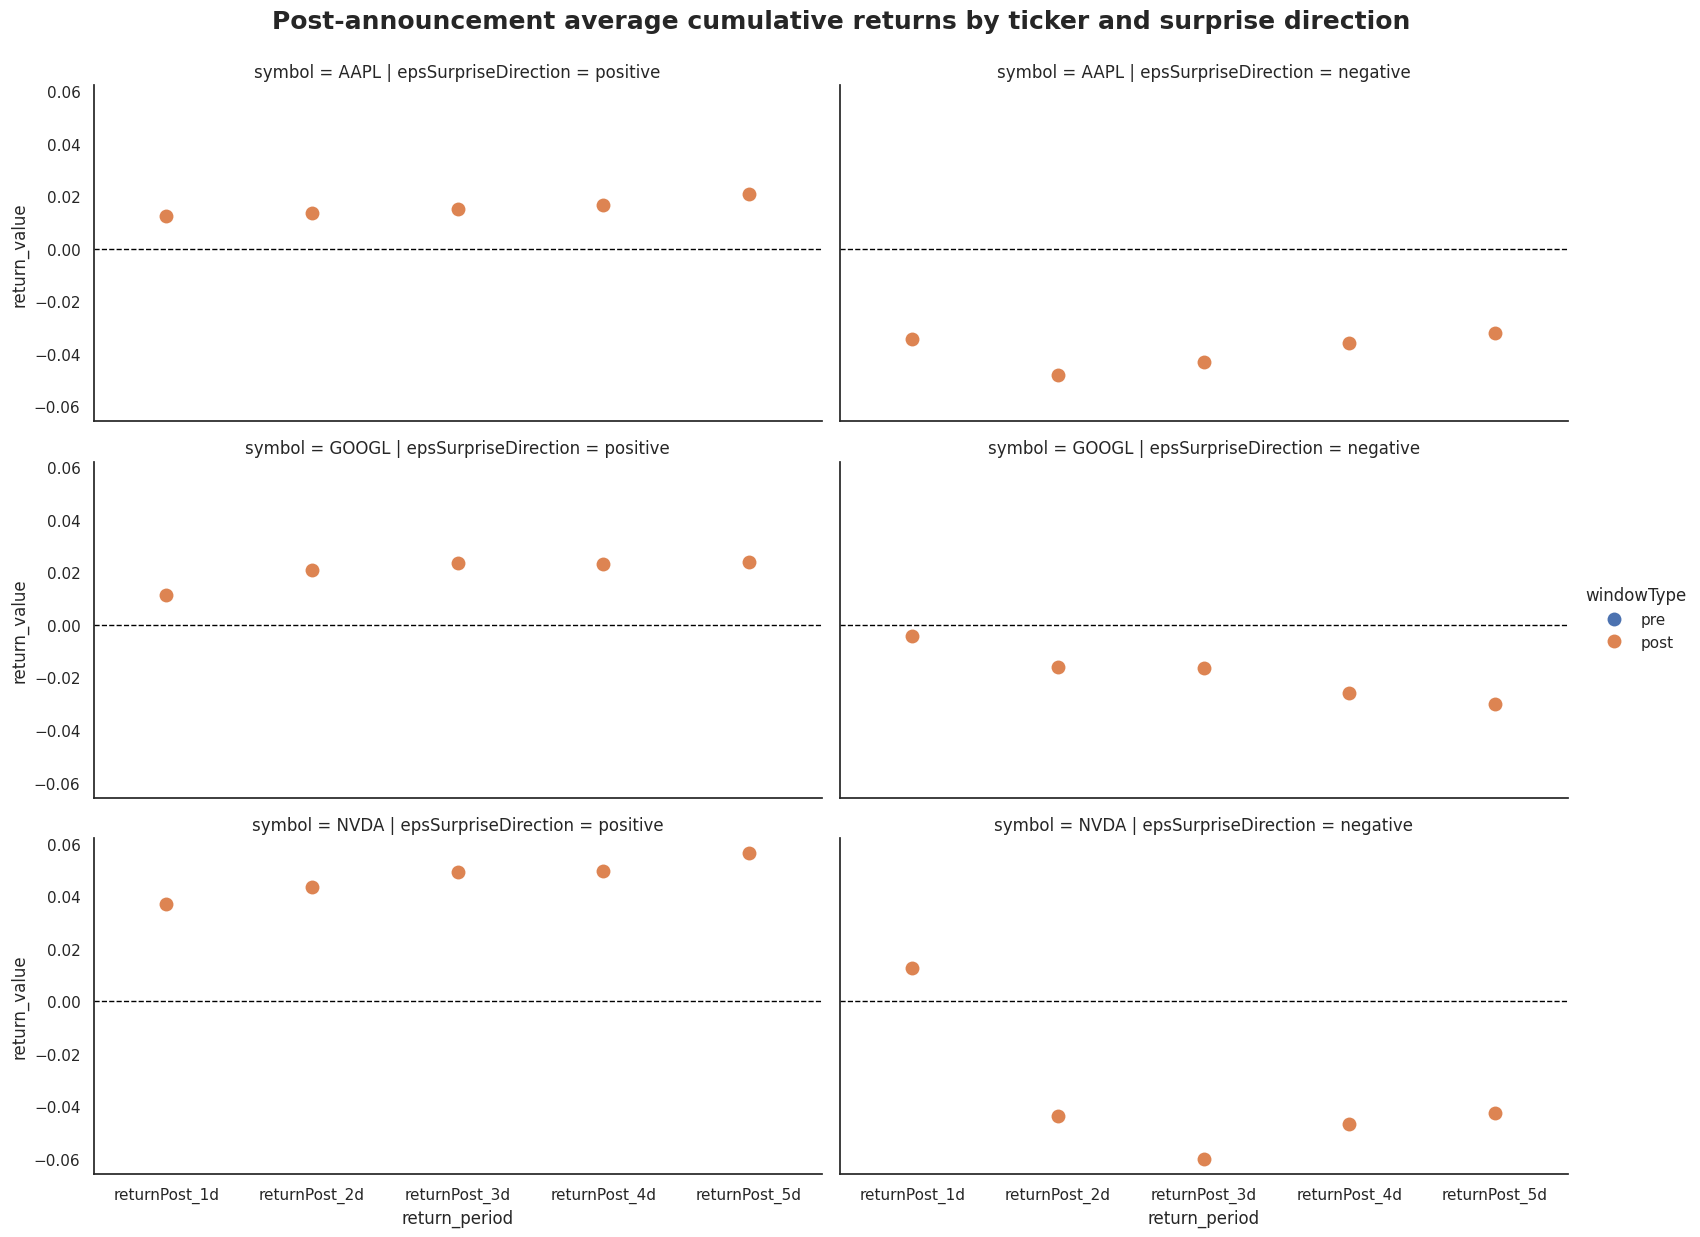

In [63]:
g = sns.catplot(
    data=windows_df.groupby(['epsSurpriseDirection', 'symbol', 'return_period', 'windowType']).mean().reset_index(),
    x='return_period',
    y='return_value',
    order = order,
    hue='windowType',
    row='symbol',
    col='epsSurpriseDirection',
    row_order = symbol_order,
    col_order = dir_order,
    hue_order = wtype_order,
    kind='strip',
    height=4,
    aspect=2,
    size = 10)

for ax in g.axes.flatten():
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed red line at 0

g.fig.suptitle('Post-announcement average cumulative returns by ticker and surprise direction', fontsize=18, fontweight='bold', y=1.03)

# Show the plot
plt.show()

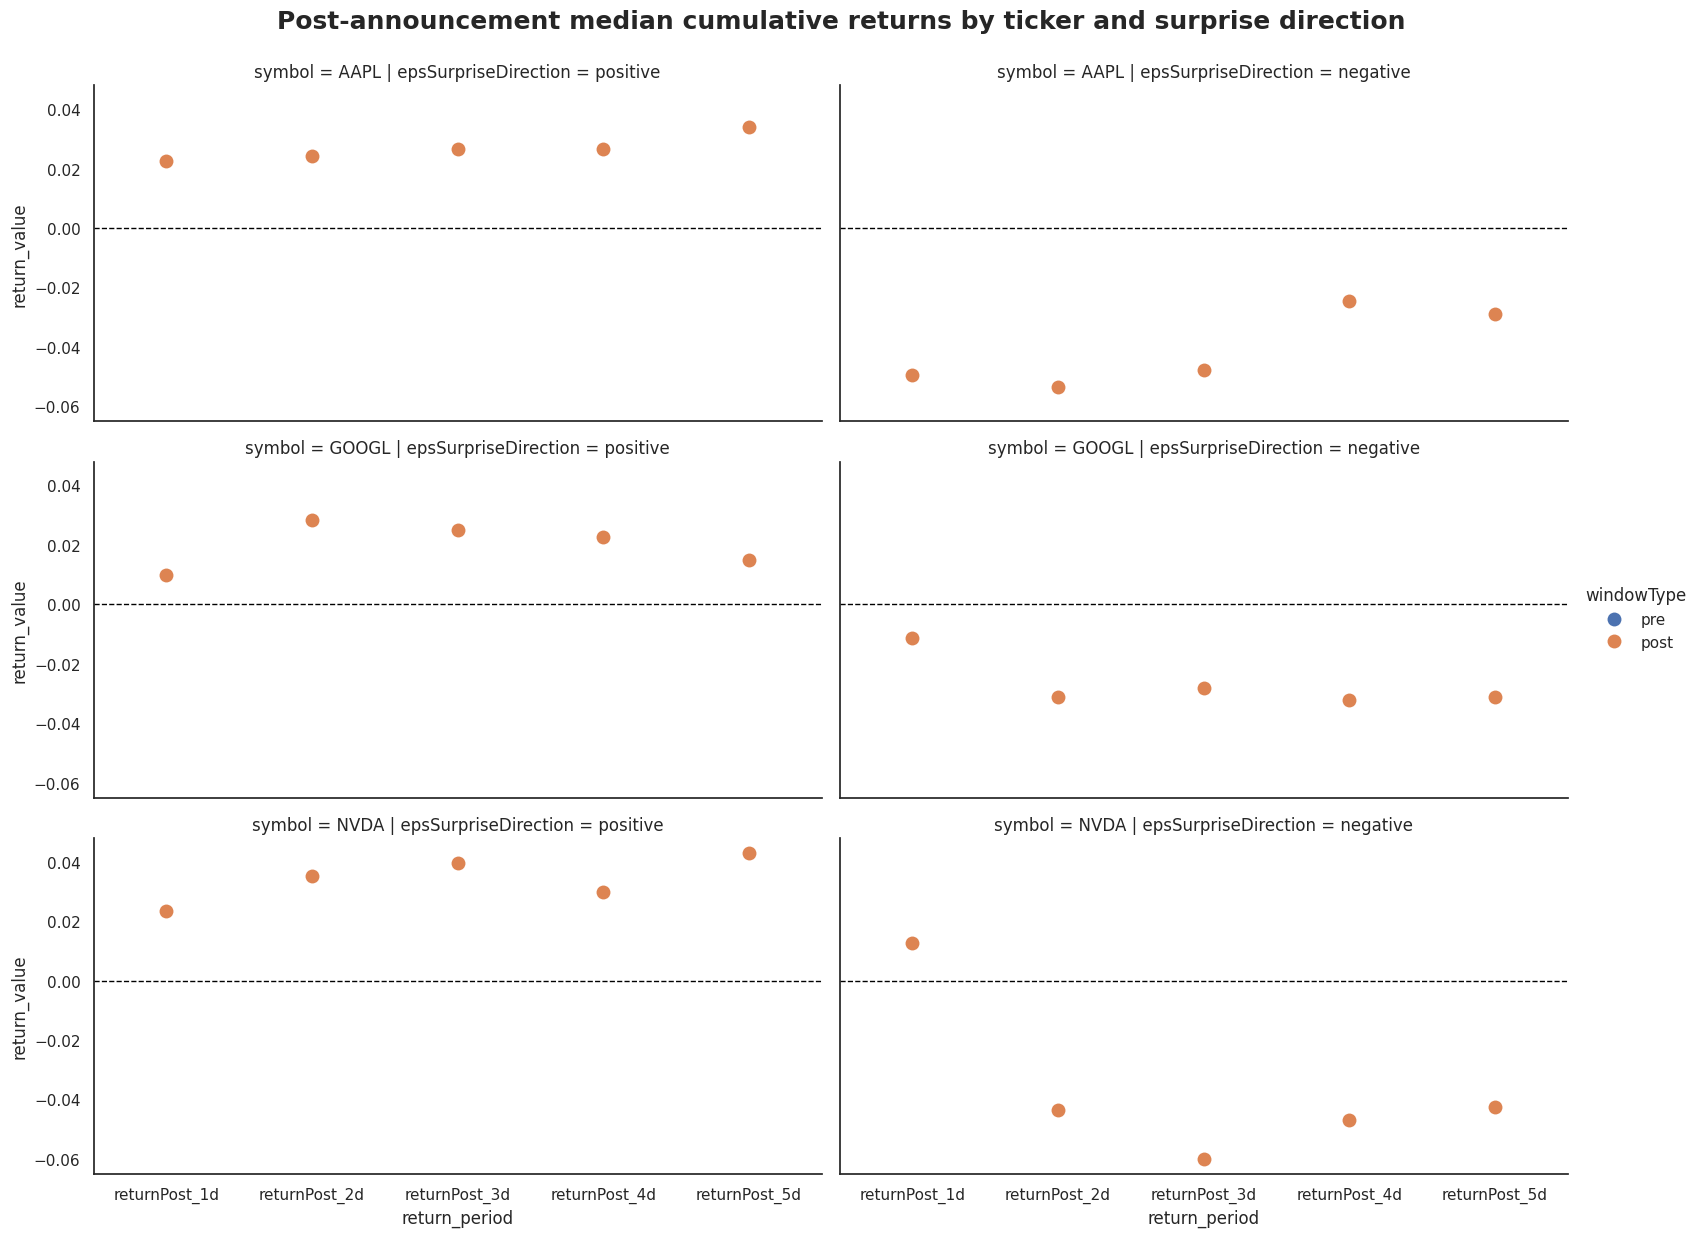

In [64]:
g = sns.catplot(
    data=windows_df.groupby(['epsSurpriseDirection', 'symbol', 'return_period', 'windowType']).median().reset_index(),
    x='return_period',
    y='return_value',
    order = order,
    hue='windowType',
    row='symbol',
    col='epsSurpriseDirection',
    row_order = symbol_order,
    col_order = dir_order,
    hue_order = wtype_order,
    kind='strip',
    height=4,
    aspect=2,
    size=10)

for ax in g.axes.flatten():
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed red line at 0


g.fig.suptitle('Post-announcement median cumulative returns by ticker and surprise direction', fontsize=18, fontweight='bold', y=1.03)


# Show the plot
plt.show()

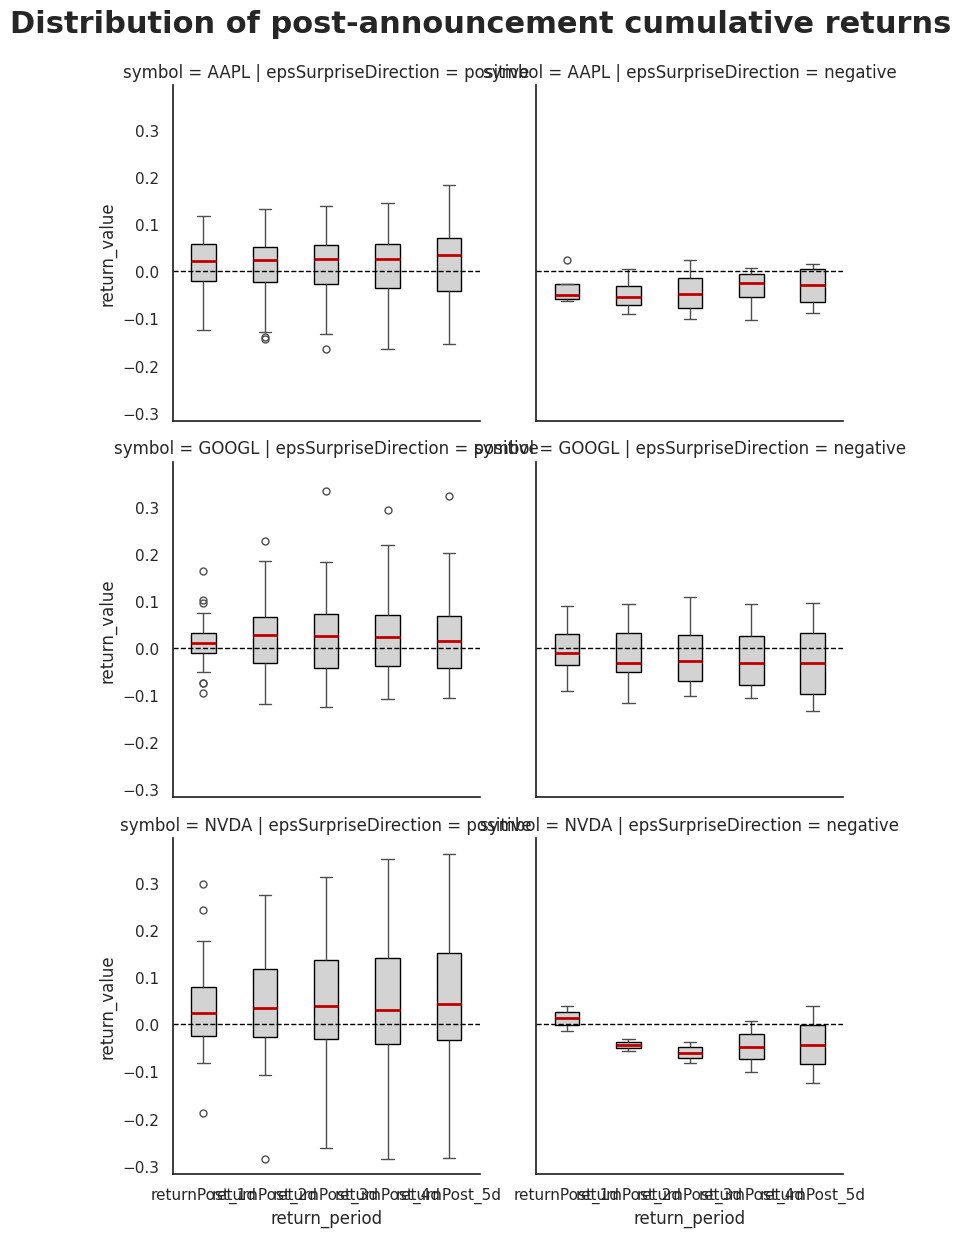

In [65]:
g = sns.catplot(
    data=windows_df,
    x='return_period',
    y='return_value',
    order = order,
    hue='windowType',
    row='symbol',
    col='epsSurpriseDirection',
    row_order = symbol_order,
    col_order = dir_order,
    hue_order = wtype_order,
    kind='box',
    estimator='mean',
    height=4,
    aspect=1,
    width = 0.4,
    legend=False,
    palette=['grey', 'lightgrey'],  # Set colors to grey and blue
    boxprops={'edgecolor': 'black'},  # Ensure box edges are visible
    medianprops={'color': '#C00000', 'linewidth': 2}  # Highlight the median in red)
)

for ax in g.axes.flatten():
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed red line at 0

g.fig.suptitle('Distribution of post-announcement cumulative returns', fontsize=22, fontweight='bold', y=1.03)

# Show the plot
plt.show()

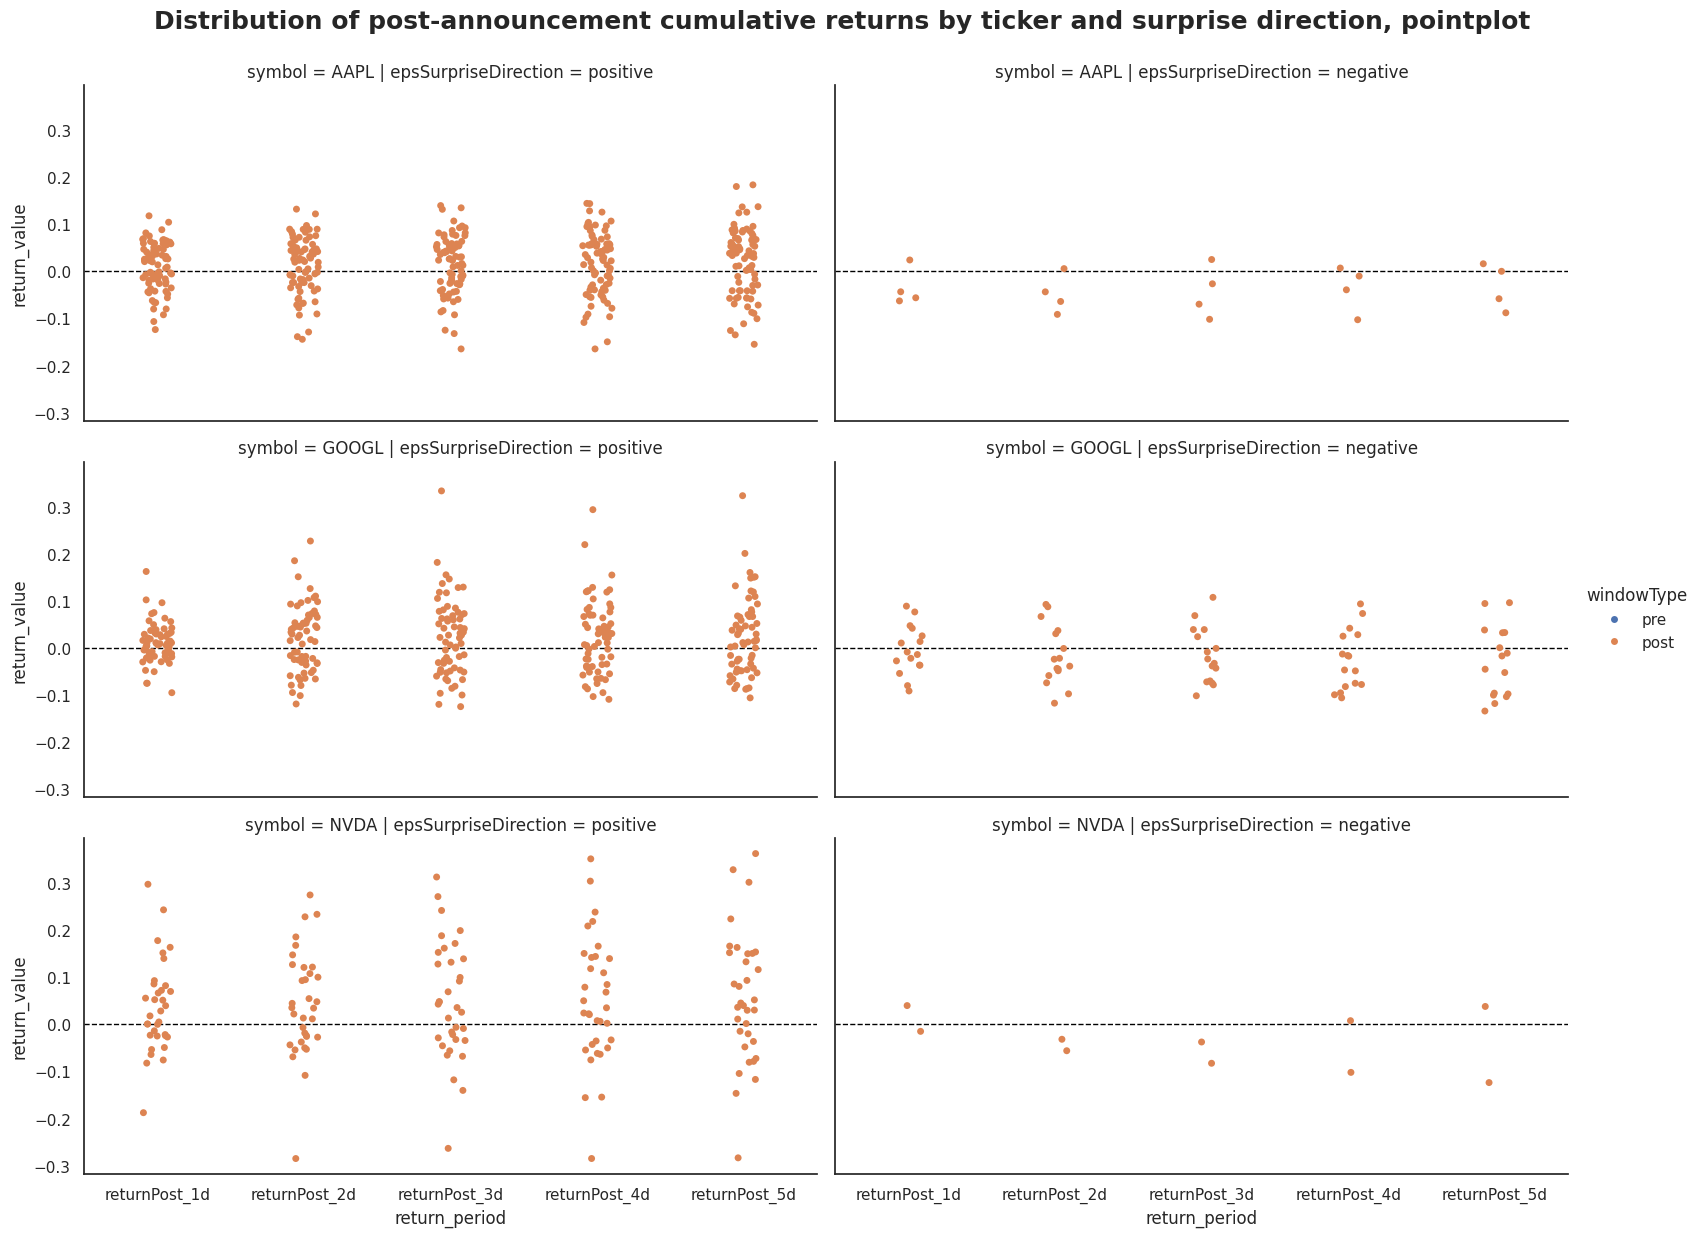

In [66]:
g = sns.catplot(
    data=windows_df,
    x='return_period',
    y='return_value',
    order = order,
    hue='windowType',
    row='symbol',
    col='epsSurpriseDirection',
    row_order = symbol_order,
    col_order = dir_order,
    hue_order = wtype_order,
    kind='strip',
    estimator='mean',
    height=4,
    aspect=2)

for ax in g.axes.flatten():
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed red line at 0

g.fig.suptitle('Distribution of post-announcement cumulative returns by ticker and surprise direction, pointplot', fontsize=18, fontweight='bold', y=1.03)

# Show the plot
plt.show()